## 1. 数据预处理

### 1.1. 数据抽样及目标Y确定

回顾数据列并识别贷后特征

首先，我们需要加载数据并查看其中包含的列。Lending Club 数据集（尤其是accepted_2007_to_2018q4.csv）包含了从贷款申请到贷款结清全周期的数据。对于A卡建模，我们只能使用在贷款申请审批那一刻就能获取到的信息。任何在贷款发放之后才产生的数据都属于“贷后数据”，必须剔除，否则会造成严重的“信息泄露”（Data Leakage），模型在训练时会看到未来的信息，导致效果虚高，但在实际应用中毫无价值。

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
import warnings

In [8]:
warnings.filterwarnings('ignore')
file_path = 'accepted_2007_to_2018q4.csv'

In [9]:
cols_to_drop = [
    # --- ID和描述性文本 ---
    'id', 'member_id', 'url', 'desc', 'title', 'emp_title',

    # --- 贷后状态和还款信息 ---
    'pymnt_plan', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
    'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
    'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
    'last_credit_pull_d', 'acc_now_delinq', 'chargeoff_within_12_mths',
    'delinq_amnt', 'mths_since_last_delinq', 'mths_since_last_record',
    'mths_since_last_major_derog',

    # --- 困难计划（Hardship Plan）相关
    'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status',
    'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date',
    'payment_plan_start_date', 'hardship_length', 'hardship_dpd',
    'hardship_loan_status', 'orig_projected_additional_accrued_interest',
    'hardship_payoff_balance_amount', 'hardship_last_payment_amount',

    # --- 债务结算（Debt Settlement）相关
    'debt_settlement_flag', 'debt_settlement_flag_date', 'settlement_status',
    'settlement_date', 'settlement_amount', 'settlement_percentage',
    'settlement_term',

    # --- 其他可能泄露信息的贷中/贷后字段
    'funded_amnt', 'funded_amnt_inv',
    'initial_list_status',
    'verification_status_joint'
]
df = pd.read_csv(file_path, low_memory=False)
print(f"数据加载成功，原始数据形状: {df.shape}")

数据加载成功，原始数据形状: (2260701, 151)


**数据采样 (2007-2014年)**

筛选出2007年至2014年的数据，并使最终样本量在6-10万左右，同时关注好坏客户的比例。

1. 时间窗口筛选:

- 数据集中通常有一个 issue_d (贷款发放日期) 的列。我们需要先将其解析为日期格式。

- 筛选 issue_d 在 '2007-01-01' 到 '2014-12-31' 之间的所有贷款。选择2014年及以前的数据是一个很好的实践，因为这保证了大部分3年期或5年期的贷款都有足够的时间来表现其最终状态（是Fully Paid还是Charged Off）。

2. 应用Y值定义:

- 在筛选出的时间窗口样本中，根据第二步的规则创建目标变量 Y。

- 剔除所有不属于“好客户”或“坏客户”定义的样本。

3. 控制样本量和比例:

- 首先，统计一下经过上述筛选后，好客户和坏客户的样本量以及坏客户率（Bad Rate）。Lending Club 的坏客户率通常在15%-20%之间。

- 假设经过筛选后，总样本量远超10万（例如，可能有几十万）。这时我们需要进行采样。

- 使用分层采样 (Stratified Sampling) 来保证采样后好坏客户的比例与原始筛选数据集中的比例基本一致。


In [10]:
df['issue_d'] = pd.to_datetime(df['issue_d'], errors='coerce')
start_date = pd.to_datetime('2007-01-01')
end_date = pd.to_datetime('2014-12-31')
df_filtered = df[(df['issue_d'] >= start_date) & (df['issue_d'] <= end_date)].copy()
print(f"筛选2007-2014年数据后，形状为: {df_filtered.shape}")

筛选2007-2014年数据后，形状为: (466345, 151)


In [11]:
existing_cols_to_drop = [col for col in cols_to_drop if col in df_filtered.columns]
df_cleaned = df_filtered.drop(columns=existing_cols_to_drop, errors='ignore')
print(f"剔除贷后及无关特征后，形状为: {df_cleaned.shape}")

剔除贷后及无关特征后，形状为: (466345, 99)


**定义目标变量 (Y)**

1. loan_status 中常见的取值有：

- Fully Paid: 全额还款。这显然是好客户 (Good)。

- Charged Off: 核销。这显然是坏客户 (Bad)。

- Current: 当前正在还款。这部分样本的状态尚不明确，无法判断其最终是好是坏。在A卡建模中，这些样本通常会被剔除，因为它们的表现期（Performance Window）不足。

- In Grace Period: 在宽限期内。同样状态不明确，剔除。

- Late (16-30 days), Late (31-120 days): 逾期。这些可以被定义为坏客户，但为了模型的明确性，通常将它们和 Charged Off 合并为一类。

- Default: 违约。这是明确的坏客户 (Bad)。

2. 定义Y的建议方案：
- 明确的好客户: loan_status == 'Fully Paid'

- 明确的坏客户: loan_status in ['Charged Off', 'Default']

- 在Lending Club数据集中，Default 状态较为少见，Charged Off 是主要的坏客户标签。可以将两者合并。

- Late (31-120 days) 也可以考虑纳入坏客户范畴，因为长期逾期最终大概率会走向核销。这可以扩大坏客户样本量，但需注意标签的一致性。

- 需要剔除的样本: 其他所有状态，包括 'Current', 'In Grace Period', 'Late (16-30 days)' 等，因为它们未来走向不确定。

3. 最终定义：

- Y = 0 (好客户): loan_status == 'Fully Paid'

- Y = 1 (坏客户): loan_status in ['Charged Off', 'Default']

过滤掉所有其他 loan_status 的样本。

In [12]:
good_status = ['Fully Paid']
bad_status = ['Charged Off', 'Default']
df_model_data = df_cleaned[df_cleaned['loan_status'].isin(good_status + bad_status)].copy()
df_model_data['Y'] = df_model_data['loan_status'].apply(lambda x: 0 if x in good_status else 1)
df_model_data = df_model_data.drop(columns=['loan_status'])
print(f"定义Y并筛选后，数据集形状: {df_model_data.shape}")
print("原始数据的好坏客户比例:")
print(df_model_data['Y'].value_counts(normalize=True))

定义Y并筛选后，数据集形状: (451060, 99)
原始数据的好坏客户比例:
Y
0    0.8304
1    0.1696
Name: proportion, dtype: float64


In [13]:
TARGET_TOTAL_SIZE = 100000  # 目标总样本量
TARGET_BAD_RATE = 0.4      # 目标坏客户比例
print(f"\n开始执行采样，目标总样本量: {TARGET_TOTAL_SIZE}, 目标坏客户比例: {TARGET_BAD_RATE:.0%}")
df_good = df_model_data[df_model_data['Y'] == 0]
df_bad = df_model_data[df_model_data['Y'] == 1]
n_bad = int(TARGET_TOTAL_SIZE * TARGET_BAD_RATE)
n_good = TARGET_TOTAL_SIZE - n_bad


开始执行采样，目标总样本量: 100000, 目标坏客户比例: 40%


In [14]:
if n_bad > len(df_bad):
    print(f"警告：所需坏客户样本数 {n_bad} 超过可用数量 {len(df_bad)}。将使用所有可用坏客户。")
    n_bad = len(df_bad)
    n_good = int(n_bad * (1 / TARGET_BAD_RATE - 1))
    print(f"好客户样本数调整为 {n_good} 以维持比例。")

if n_good > len(df_good):
    print(f"警告：所需好客户样本数 {n_good} 超过可用数量 {len(df_good)}。将使用所有可用好客户。")
    n_good = len(df_good)

print(f"计划抽取 {n_good} 个好客户样本和 {n_bad} 个坏客户样本。")
good_sample = df_good.sample(n=n_good, random_state=42)
bad_sample = df_bad.sample(n=n_bad, random_state=42)


计划抽取 60000 个好客户样本和 40000 个坏客户样本。


In [15]:
final_df = pd.concat([good_sample, bad_sample])
final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)
print("采样完成。")
print("\n--- 数据准备完成 ---")
print(f"最终数据集形状: {final_df.shape}")
print("\n最终数据集好坏客户分布:")
print(final_df['Y'].value_counts())
print("\n最终数据集好坏客户比例:")
print(final_df['Y'].value_counts(normalize=True))

print("\n最终数据集前5行预览:")
print(final_df.head())
final_df.to_csv('lending_club_cleaned_resampled.csv', index=False)

采样完成。

--- 数据准备完成 ---
最终数据集形状: (100000, 99)

最终数据集好坏客户分布:
Y
0    60000
1    40000
Name: count, dtype: int64

最终数据集好坏客户比例:
Y
0    0.6
1    0.4
Name: proportion, dtype: float64

最终数据集前5行预览:
   loan_amnt        term  int_rate  installment grade sub_grade emp_length  \
0    16750.0   60 months     17.77       423.25     D        D1  10+ years   
1    22000.0   60 months     16.59       541.92     D        D1    8 years   
2     8500.0   36 months     10.99       278.24     B        B2  10+ years   
3     1800.0   36 months     21.70        68.47     E        E2    7 years   
4    29450.0   60 months     20.20       783.53     E        E3    3 years   

  home_ownership  annual_inc verification_status    issue_d  \
0       MORTGAGE     53000.0            Verified 2013-05-01   
1       MORTGAGE     68000.0            Verified 2014-04-01   
2           RENT     50000.0            Verified 2013-11-01   
3           RENT     29000.0            Verified 2013-11-01   
4            OWN     85000.0

### 1.2. 数据预处理（缺失值与异常值）

**数据格式转换**

在进行计算之前，必须确保所有数据都处于正确的格式。Lending Club数据集中有几个典型的“伪数值”列，它们看起来是数字，但因为包含单位（如%, months）而被存储为字符串（object类型）。

主要处理对象：

- term: " 36 months" -> 36 (数值)

- int_rate: "10.33%" -> 0.1033 (浮点数)

- revol_util: "54.8%" -> 0.548 (浮点数)

- emp_length: "< 1 year", "10+ years", "n/a" -> 0, 10, NaN (数值)



In [16]:
print("   - 转换数据格式...")
if 'term' in final_df.columns: final_df['term'] = final_df['term'].str.extract('(\d+)').astype(float)
if 'int_rate' in final_df.columns: final_df['int_rate'] = final_df['int_rate'].astype(float) / 100.0
if 'revol_util' in final_df.columns: final_df['revol_util'] = final_df['revol_util'].astype(float) / 100.0
emp_map = {'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10}
if 'emp_length' in final_df.columns: final_df['emp_length'] = final_df['emp_length'].map(emp_map)
if 'earliest_cr_line' in final_df.columns: final_df['earliest_cr_line'] = pd.to_datetime(final_df['earliest_cr_line'], errors='coerce')
if 'issue_d' in final_df.columns: final_df['issue_d'] = pd.to_datetime(final_df['issue_d'], errors='coerce')
if 'earliest_cr_line' in final_df.columns and 'issue_d' in final_df.columns:
    final_df['credit_history_months'] = ((final_df['issue_d'] - final_df['earliest_cr_line']).dt.days) / 30.0
cols_to_remove_after_processing = ['issue_d', 'earliest_cr_line', 'zip_code', 'addr_state', 'sub_grade', 'emp_title']
final_df = final_df.drop(columns=[col for col in cols_to_remove_after_processing if col in final_df.columns])


   - 转换数据格式...


**缺失值填充**

1. 联合申请与第二申请人特征 (Joint & Secondary Applicant Features)

- 特征列表:

`annual_inc_joint, dti_joint, revol_bal_joint

sec_app_fico_range_low, sec_app_fico_range_high, sec_app_earliest_cr_line, sec_app_inq_last_6mths, sec_app_mort_acc, sec_app_open_acc, sec_app_revol_util, sec_app_open_act_il, sec_app_num_rev_accts, sec_app_chargeoff_within_12_mths, sec_app_collections_12_mths_ex_med, sec_app_mths_since_last_major_derog
`
- 业务含义: 这些特征全部与“联合申请”或“第二申请人”有关。例如 annual_inc_joint 是联合申请人的总年收入，sec_app_fico_range_low 是第二申请人的FICO分。

- 缺失原因分析: 你的数据集中 application_type 大部分都是 'Individual' (个人申请)。只有当类型为 'Joint App' 时，这些字段才会有值。因此，对于99%的个人申请者来说，这些字段必然是缺失的。

- 处理建议: 删除

- 理由: A卡模型目标是评估个人的信用风险。联合申请人的信息对于绝大多数样本是无效的，保留它们没有意义。

2. “距离上次...至今的月数”类特征 (Months Since... Features)

这类特征非常特殊，它们的缺失通常代表**“从未发生过”**，这是非常有价值的信用表现信息。

- 特征列表:

`mths_since_rcnt_il: 最近一次分期付款账户开立至今的月数。

mths_since_recent_bc_dlq: 最近一次信用卡逾期至今的月数。

mths_since_recent_revol_delinq: 最近一次循环贷逾期至今的月数。`

- 业务含义: 记录了某个“坏事件”（如逾期）或“普通事件”（如开户）距离现在有多久。

- 缺失原因分析:mths_since_recent_bc_dlq 缺失，通常意味着该客户近期没有信用卡逾期记录。这是一个非常正面的信号！mths_since_rcnt_il 缺失，可能意味着客户没有分期付款账户。

- 处理建议: 保留，并进行特殊填充。

- 错误方法: 用0填充。0 在这里的业务含义是“这个月刚刚发生”，与“从未发生”的含义完全相反。

- 正确方法1 (创建标志位):创建一个新的虚拟变量（dummy variable）。例如，从 mths_since_recent_bc_dlq 创建 had_recent_bc_dlq。如果原始值存在，had_recent_bc_dlq = 1；如果原始值缺失，had_recent_bc_dlq = 0。这样就明确地把“是否发生过”这个信息提取出来了。

- 正确方法2 (特殊值填充):用一个非常大的数（如 999）来填充缺失值。这在业务上可以解释为“很久很久以前发生过（或从未发生）”。对于树模型（如XGBoost, LightGBM）来说，它可以直接学会将 999 作为一个特殊的分割点。

- 对于逻辑回归，需要先进行分箱（WOE），999 会自然地落入一个专门的箱体，代表“无此记录”的群体。

3. 其他征信表现类特征

这些是描述客户信贷行为的变量，缺失也大多因为“不适用”。

- 特征列表:

`il_util: 分期贷款账户的额度使用率。

all_util: 所有账户（包括分期和循环贷）的总额度使用率。

inq_fi: 在金融机构的查询次数。

total_cu_tl: 授信额度为0的账户数。

inq_last_12m: 过去12个月的查询次数。

open_acc_6m, open_act_il, open_il_12m, open_il_24m, open_rv_12m, open_rv_24m: 不同时间窗口内开户情况的统计。

max_bal_bc: 信用卡最大余额。

total_bal_il: 分期贷款账户总余额。`

- 缺失原因分析:il_util 缺失，意味着客户可能没有分期贷款账户。inq_fi 或 inq_last_12m 缺失，可能意味着客户近期没有在金融机构的查询记录。

- 处理建议: 大部分可以保留，用0填充是合理的。

- 理由: 和“Months Since”不同，这些是状态或计数类变量。如果一个客户没有分期贷款，那么他的分期贷款使用率（il_util）和总余额（total_bal_il）记为 0 是符合业务逻辑的。同理，如果没有查询记录（inq_...），查询次数记为 0 也是完全正确的。



In [17]:
print("   - 精细化处理缺失值...")
cols_to_fill_999 = [
    'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq',
    'mths_since_recent_inq', 'mo_sin_rcnt_rev_tl_op', 'mths_since_recent_bc', 'mo_sin_rcnt_tl'
]
cols_to_fill_0 = [
    'il_util', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'open_acc_6m',
    'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m',
    'max_bal_bc', 'total_bal_il', 'emp_length', 'pub_rec_bankruptcies',
    'collections_12_mths_ex_med', 'mo_sin_old_il_acct', 'num_tl_120dpd_2m',
    'avg_cur_bal', 'mo_sin_old_rev_tl_op', 'num_actv_rev_tl', 'num_il_tl', 'num_op_rev_tl',
    'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths',
    'mort_acc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_bc_sats', 'num_bc_tl',
    'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_30dpd', 'num_tl_90g_dpd_24m',
    'num_tl_op_past_12m', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
    'total_il_high_credit_limit'
]
cols_to_fill_median = [
    'dti', 'revol_util', 'credit_history_months', 'last_fico_range_high', 'last_fico_range_low',
    'pct_tl_nvr_dlq', 'bc_open_to_buy', 'bc_util', 'percent_bc_gt_75'
]
ALL_COLS_TO_KEEP = cols_to_fill_999 + cols_to_fill_0 + cols_to_fill_median

missing_rates = final_df.isnull().sum() / len(final_df)
high_missing_cols = missing_rates[missing_rates > 0.4].index.tolist()
cols_to_actually_drop = [col for col in high_missing_cols if col not in ALL_COLS_TO_KEEP]
if cols_to_actually_drop:
    final_df = final_df.drop(columns=cols_to_actually_drop)
print(f"   -> 精准删除完成：删除了 {len(cols_to_actually_drop)} 个无用的高缺失率特征。")

for col in cols_to_fill_999:
    if col in final_df.columns: final_df[col].fillna(999, inplace=True)
for col in cols_to_fill_0:
    if col in final_df.columns: final_df[col].fillna(0, inplace=True)
for col in cols_to_fill_median:
    if col in final_df.columns and final_df[col].isnull().any():
        median_val = final_df[col].median()
        final_df[col].fillna(median_val, inplace=True)
print("   -> 针对性填充完成。")

final_missing_count = final_df.isnull().sum().sum()
if final_missing_count == 0:
    print(f"   -> 所有缺失值均已成功填充！")
else:
    print(f"   -> 警告：仍然存在 {final_missing_count} 个缺失值，请检查！")
    print(final_df.isnull().sum()[final_df.isnull().sum() > 0])

   - 精细化处理缺失值...
   -> 精准删除完成：删除了 15 个无用的高缺失率特征。
   -> 针对性填充完成。
   -> 所有缺失值均已成功填充！


**异常值处理**

In [18]:

cols_for_strict_cap = ['annual_inc']

cols_for_standard_cap = [
    'dti', 'revol_bal', 'tot_cur_bal', 'total_rev_hi_lim',
    'tot_hi_cred_lim', 'total_bal_ex_mort', 'avg_cur_bal'
]

In [19]:
import numpy as np
print("   - 对超高偏态特征进行99.5%盖帽...")
for col in cols_for_strict_cap:
    if col in final_df.columns:
        upper_bound = final_df[col].quantile(0.995)
        final_df[col] = np.clip(final_df[col], a_min=None, a_max=upper_bound)

print("   - 对其他关键特征进行99%盖帽...")
for col in cols_for_standard_cap:
    if col in final_df.columns:
        upper_bound = final_df[col].quantile(0.99)
        final_df[col] = np.clip(final_df[col], a_min=None, a_max=upper_bound)

   - 对超高偏态特征进行99.5%盖帽...
   - 对其他关键特征进行99%盖帽...


In [20]:
print("   - 对其余所有数值特征进行标准的1%和99%盖帽...")
all_numeric_cols = final_df.select_dtypes(include=np.number).columns.tolist()
if 'Y' in all_numeric_cols:
    all_numeric_cols.remove('Y')

   - 对其余所有数值特征进行标准的1%和99%盖帽...


In [21]:
processed_cols = cols_for_strict_cap + cols_for_standard_cap
remaining_numeric_cols = [col for col in all_numeric_cols if col not in processed_cols]

for col in remaining_numeric_cols:
    lower_bound = final_df[col].quantile(0.01)
    upper_bound = final_df[col].quantile(0.99)
    final_df[col] = np.clip(final_df[col], lower_bound, upper_bound)

print("异常值处理完成。")

异常值处理完成。


In [22]:
print(final_df.describe())

           loan_amnt           term       int_rate    installment  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean    14549.261750      43.309440       0.143859     437.698742   
std      8331.070146      11.045355       0.044352     242.624141   
min      1800.000000      36.000000       0.060300      58.050000   
25%      8000.000000      36.000000       0.111400     262.780000   
50%     12600.000000      36.000000       0.141600     386.335000   
75%     20000.000000      60.000000       0.172700     573.700000   
max     35000.000000      60.000000       0.249900    1195.880000   

          emp_length     annual_inc            dti    delinq_2yrs  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        5.685700   70671.463217      17.593132       0.273080   
std         3.761401   40007.395128       7.835864       0.691587   
min         0.000000    4000.000000       0.000000       0.000000   
25%         2.000000   45000.0000

In [18]:
print(final_df.head())

   loan_amnt  term  int_rate  installment grade  emp_length home_ownership  \
0    16750.0  60.0    0.1777       423.25     D        10.0       MORTGAGE   
1    22000.0  60.0    0.1659       541.92     D         8.0       MORTGAGE   
2     8500.0  36.0    0.1099       278.24     B        10.0           RENT   
3     1800.0  36.0    0.2170        68.47     E         7.0           RENT   
4    29450.0  60.0    0.2020       783.53     E         3.0            OWN   

   annual_inc verification_status             purpose    dti  delinq_2yrs  \
0     53000.0            Verified  debt_consolidation  34.60          0.0   
1     68000.0            Verified  debt_consolidation  31.42          2.0   
2     50000.0            Verified  debt_consolidation  22.61          0.0   
3     29000.0            Verified            vacation  22.31          0.0   
4     85000.0     Source Verified      small_business   7.14          0.0   

   fico_range_low  fico_range_high  inq_last_6mths  open_acc  pub_re

## 2. 探索性数据分析 (EDA)

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
font_path = '/System/Library/Fonts/Hiragino Sans GB.ttc'

font_prop = FontProperties(fname=font_path, size=12)
font_prop_title = FontProperties(fname=font_path, size=16)

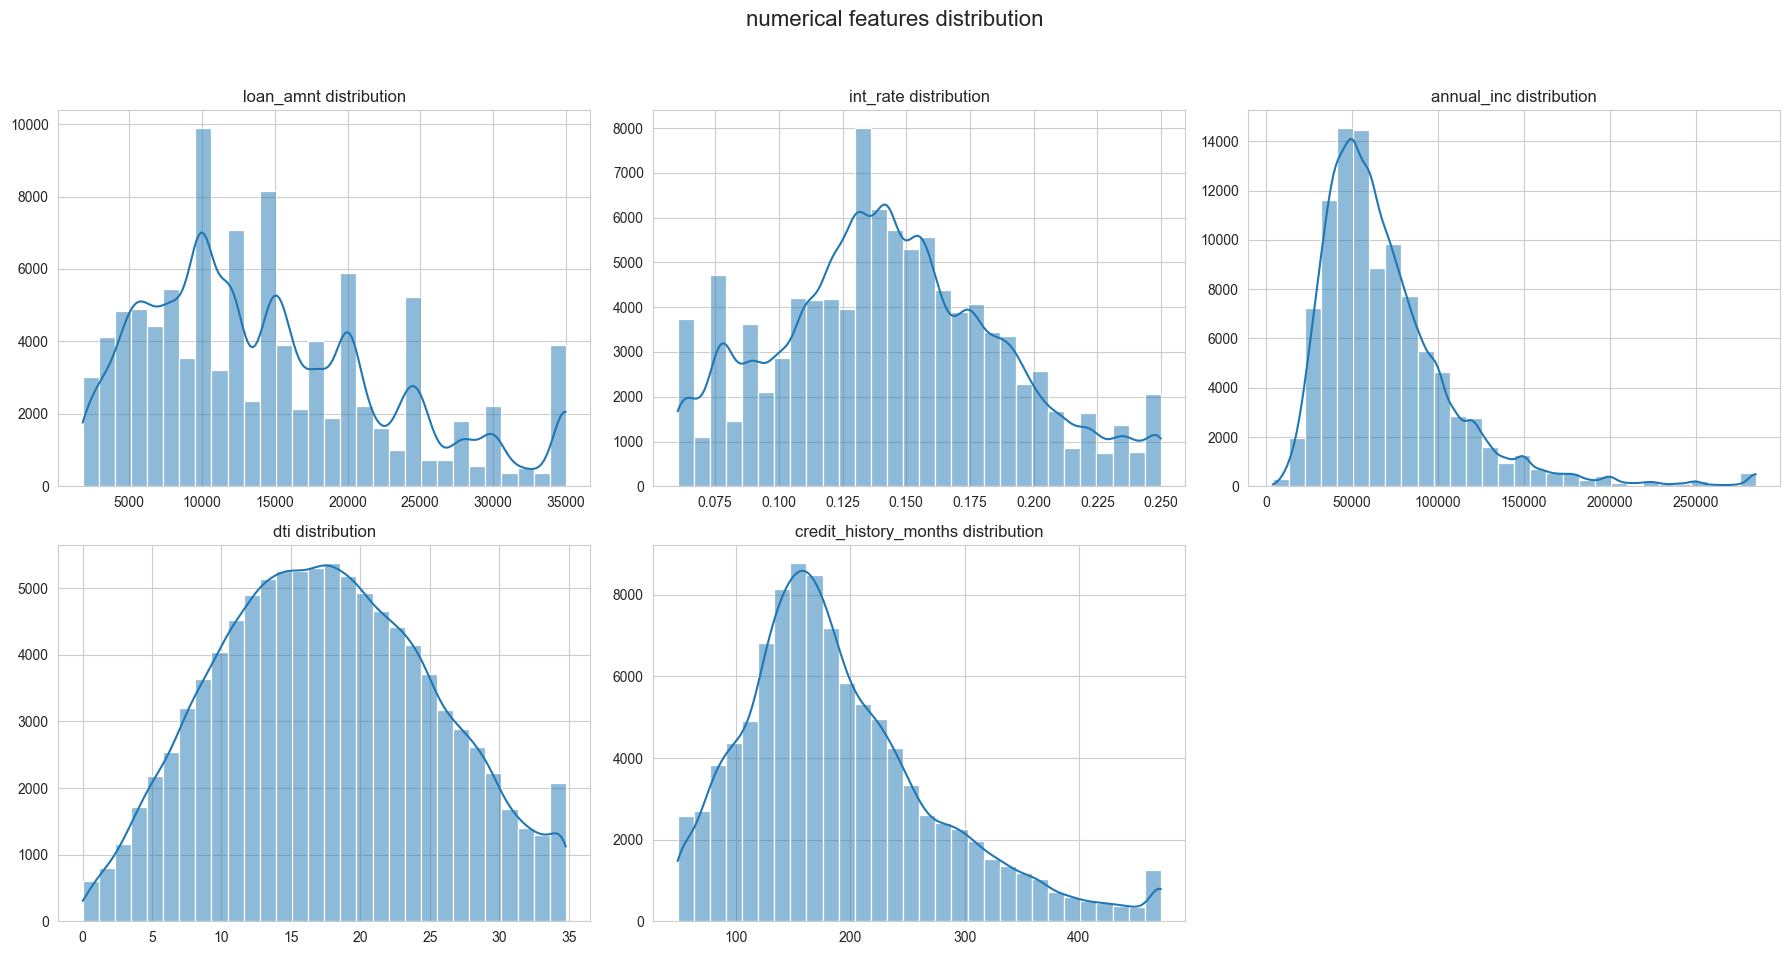

In [24]:
numeric_features = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'credit_history_months']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('numerical features distribution', fontsize=16)

axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    sns.histplot(final_df[feature], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'{feature} distribution')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
if len(numeric_features) < len(axes):
    for j in range(len(numeric_features), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

- loan_amnt distribution (贷款金额分布): 存在多个明显的“波峰”，尤其是在10000, 20000, 35000等整数关口。这说明客户申请的金额倾向于这些整数金额，而非平滑分布。

- int_rate distribution (利率分布): 利率分布相对集中，但整体向右侧（高利率）有一个长尾，说明大部分贷款利率居中，少数客户的利率较高。

- annual_inc distribution (年收入分布): 这是典型的严重右偏态分布。大量客户的收入集中在较低的区间（例如5万-10万），只有极少数客户有非常高的收入。这验证了我们之前做异常值盖帽处理的必要性。

- dti distribution (债务收入比分布): 基本呈现正态分布，中心在15-20左右，说明大部分客户的债务负担处于一个相对合理的水平。

- credit_history_months distribution (信用历史长度分布): 呈现右偏态分布，大部分客户的信用历史集中在100-250个月（约8-20年），拥有超长信用历史的客户较少。

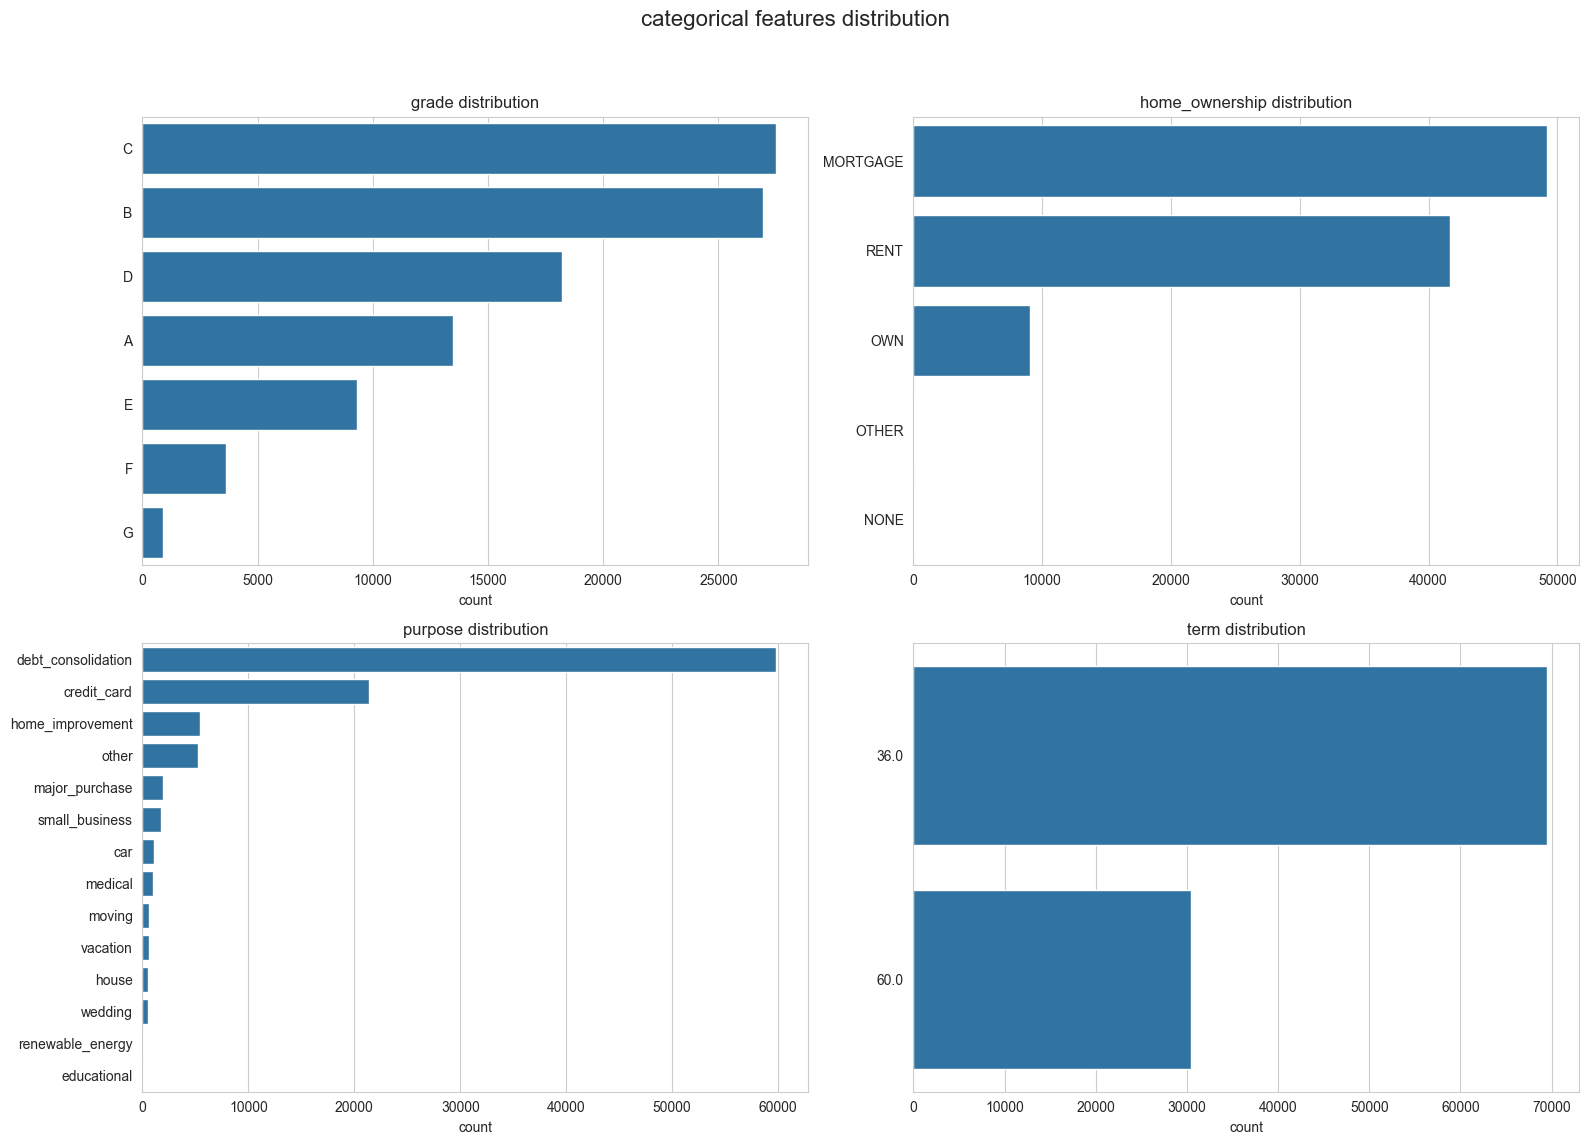

In [25]:
categorical_features = ['grade', 'home_ownership', 'purpose', 'term']
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('categorical features distribution', fontsize=16)
axes = axes.flatten()
for i, feature in enumerate(categorical_features):
    sns.countplot(y=final_df[feature], ax=axes[i], order=final_df[feature].value_counts().index)
    axes[i].set_title(f'{feature} distribution')
    axes[i].set_xlabel('count')
    axes[i].set_ylabel('')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

- grade distribution (等级分布): 贷款主要集中在 B级 和 C级，其次是D级和A级。这表明银行的核心客户群是中等风险的客户，风险最高的F级和G级占比较少，符合稳健的经营策略。

- home_ownership distribution (住房情况分布): 绝大部分申请人处于 MORTGAGE (按揭) 或 RENT (租房) 状态，这两者构成了客户主体。自有住房 (OWN) 的客户占比较少。

- purpose distribution (贷款目的分布): debt_consolidation (债务整合) 是绝对主导的贷款目的，远超其他所有类别。这说明Lending Club的核心业务是帮助客户整合现有债务。

- term distribution (贷款期限分布): 36期 的贷款产品数量显著多于60期的，表明短期贷款是业务的主流。

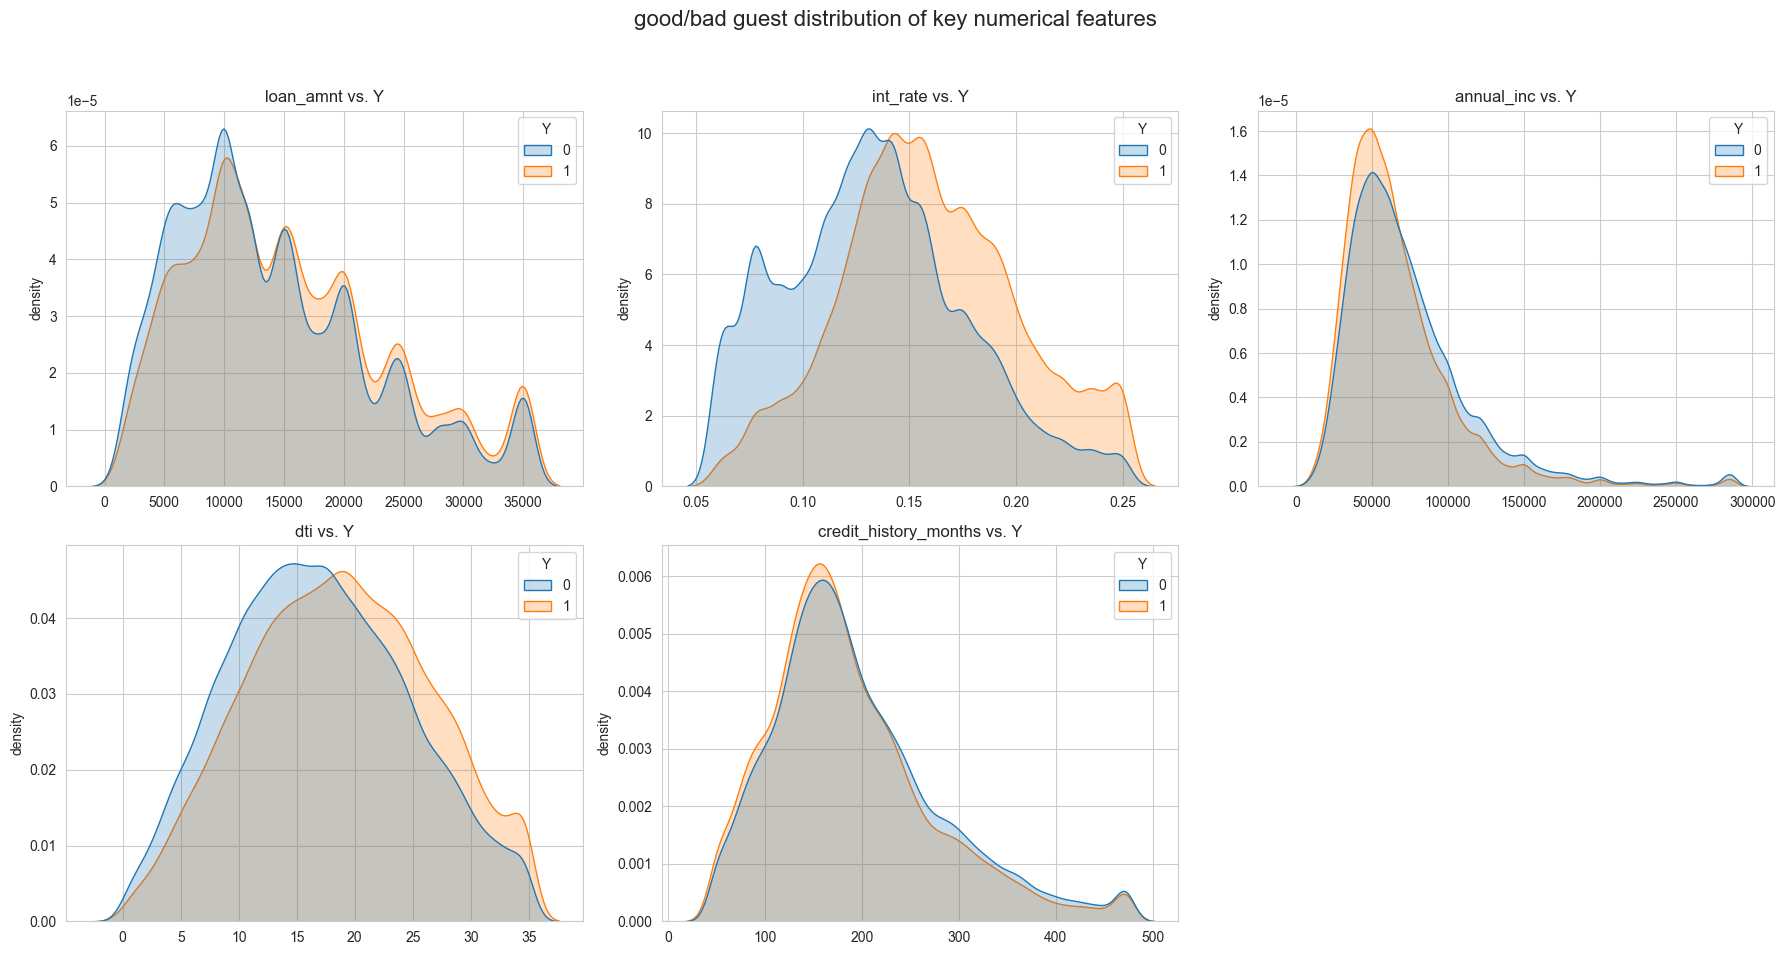

In [26]:

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('good/bad guest distribution of key numerical features', fontsize=16)
axes = axes.flatten()
for i, feature in enumerate(numeric_features):
    sns.kdeplot(data=final_df, x=feature, hue='Y', fill=True, ax=axes[i], common_norm=False)
    axes[i].set_title(f'{feature} vs. Y')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('density')
if len(numeric_features) < len(axes):
    for j in range(len(numeric_features), len(axes)):
        fig.delaxes(axes[j])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

- loan_amnt vs. Y (贷款金额对比): 好客户(Y=0)和坏客户(Y=1)的分布曲线高度重叠。这表明，单看贷款金额本身，很难有效区分一个客户的好坏。它的预测能力较弱。

- int_rate vs. Y (利率对比): 分离效果非常显著！ 坏客户（橙色曲线）的整体分布明确地偏向右侧的高利率区，而好客户（蓝色曲线）则集中在低利率区。结论：int_rate 是一个极其强大的预测变量。

- annual_inc vs. Y (年收入对比): 两条曲线重叠度很高，但仔细看，好客户（蓝色）的“波峰”比坏客户（橙色）略微靠右。这说明好客户的平均收入水平略高，但这种区分度不强，预测能力有限。

- dti vs. Y (债务收入比对比): 有较为明显的分离。坏客户的分布更偏向右侧的高dti区域。这说明债务负担越重的客户，违约风险越高。dti 具有不错的预测能力。

- credit_history_months vs. Y (信用历史长度对比): 两条曲线几乎完全重合，看不出任何差异。这表明，信用历史的长短本身似乎并不能很好地区分客户好坏，它的预测能力很弱。

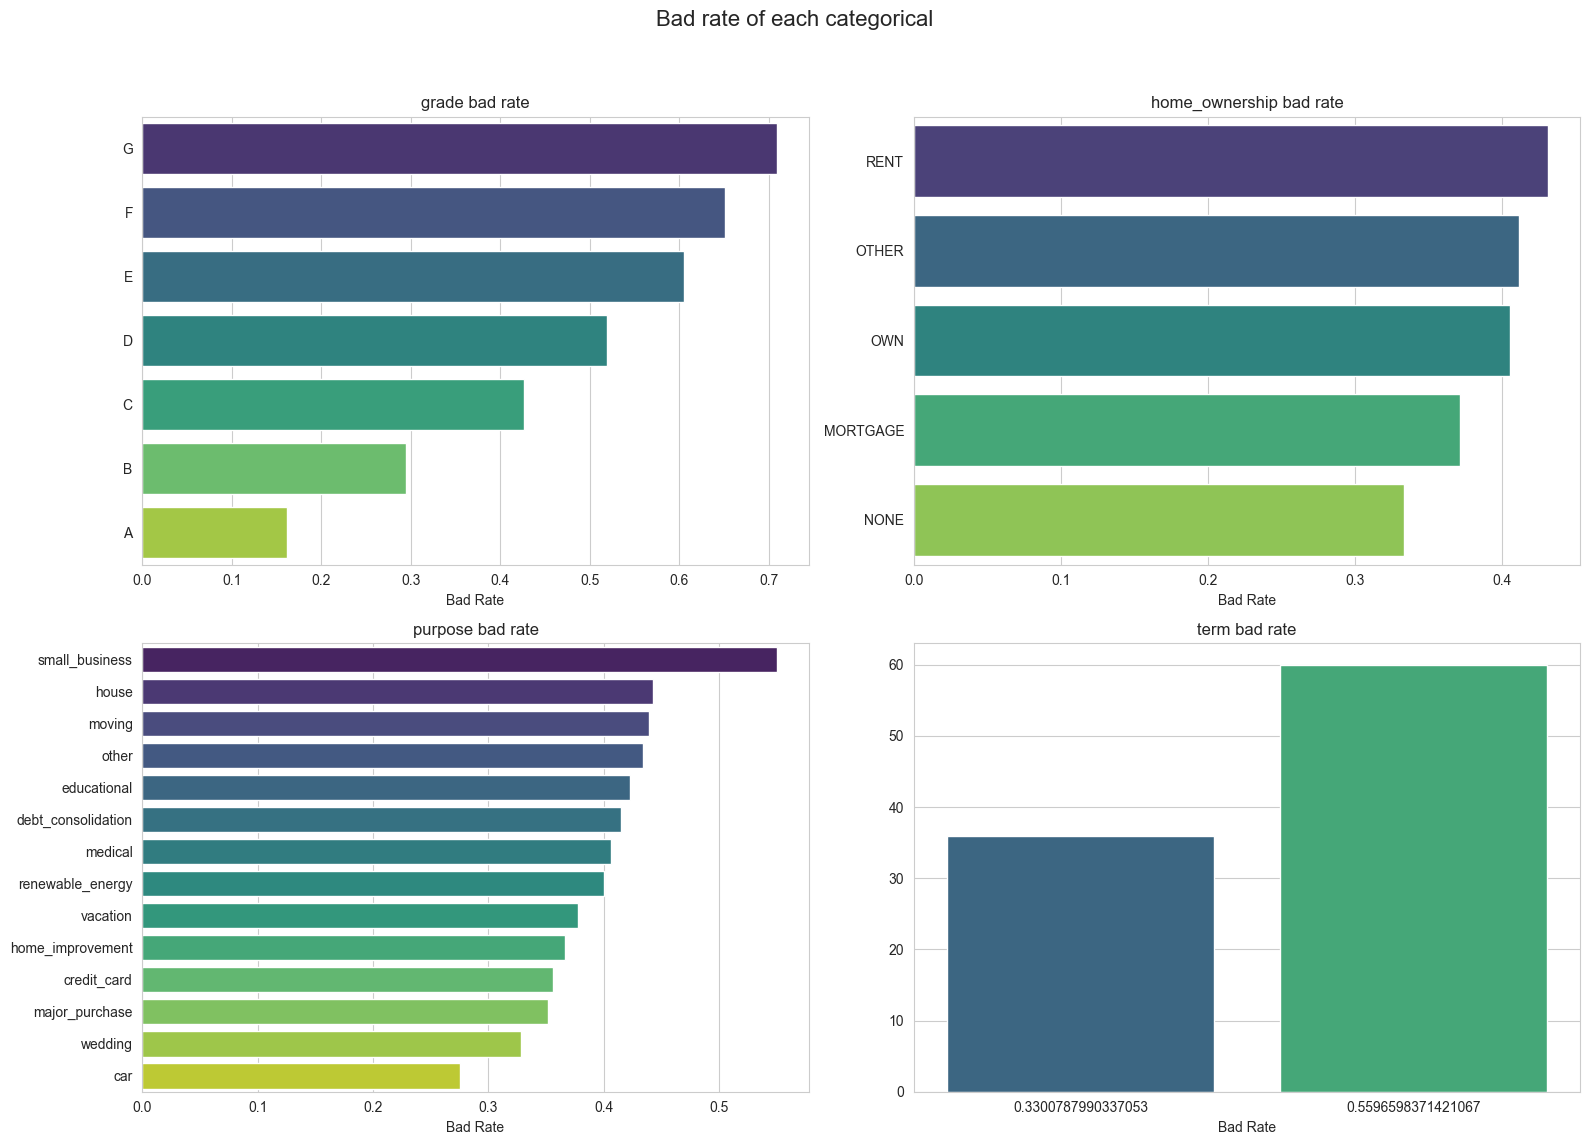

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Bad rate of each categorical', fontsize=16)
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    bad_rate = final_df.groupby(feature)['Y'].mean().sort_values(ascending=False)
    sns.barplot(y=bad_rate.index, x=bad_rate.values, ax=axes[i], palette='viridis')
    axes[i].set_title(f'{feature} bad rate')
    axes[i].set_xlabel('Bad Rate')
    axes[i].set_ylabel('')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

- grade bad rate (等级的坏客户率): 趋势极其清晰！ 随着等级从A到G，坏客户率呈现出严格的单调递增关系。A级的坏客户率最低，G级最高。

- home_ownership bad rate (住房情况的坏客户率): 不同类别之间有一定差异。MORTGAGE（按揭）的坏客户率相对较低，而RENT（租房）的坏客户率最高。这表明该特征具有一定的预测能力。

- purpose bad rate (贷款目的的坏客户率): 不同目的的风险差异巨大。small_business（小生意）的坏客户率遥遥领先，风险极高。而car（购车）、wedding（婚礼）等消费类目的风险则低得多。结论：purpose 是一个很强的预测变量。

- term bad rate (贷款期限的坏客户率): 60期 的坏客户率显著高于 36期。这符合业务逻辑：贷款时间越长，未来发生违约的不确定性越大。结论：term 是一个简单有效的预测变量。

## 3. 特征工程 (WOE & IV)：

### 3.1 核心概念简介
a) 分箱 (Binning)
- 连续变量: 将连续的数值范围切分成若干个区间（“箱”）。例如，将年收入分为 [0, 5万), [5万, 10万), [10万, ...] 等。最优的分箱方法是监督式分箱（如卡方分箱, ChiMerge），它能确保分出的每个箱在好坏客户比例上有显著差异。

- 离散变量: 类别本身就是“箱”。但如果类别过多或某些类别样本太少，需要将稀有类别合并成一个“其他”箱。

b) WOE (Weight of Evidence - 证据权重)
WOE衡量的是每个“箱”中，好客户和坏客户的比例与总体好坏客户比例的差异。它能量化每个箱的“风险水平”。

- WOE > 0: 说明这个箱里的好客户占比较高，是低风险群体。

- WOE < 0: 说明这个箱里的坏客户占比较高，是高风险群体。

- WOE ≈ 0: 说明这个箱的风险水平接近整体平均。

c) IV (Information Value - 信息价值)
IV值是基于WOE计算出来的，它代表了一个特征整体的预测能力。IV值越高，特征的预测能力越强。

- < 0.02: 无预测能力 (Useless)

- 0.02 - 0.1: 预测能力弱 (Weak)

- 0.1 - 0.3: 预测能力中等 (Medium)

- 0.3 - 0.5: 预测能力强 (Strong)

- 0.5: 预测能力极强，可能存在信息泄露 (Suspicious)

### 3.2 特征预筛选

1. 零方差特征 (标准差 std = 0)没有任何区分能力，必须移除。以下特征的 std (标准差) 为0：collections_12_mths_ex_med
policy_code
open_acc_6m
open_act_il
open_il_12m
open_il_24m
mths_since_rcnt_il (值为999)
total_bal_il
il_util
open_rv_12m
open_rv_24m
max_bal_bc
all_util
inq_fi
total_cu_tl
inq_last_12m
num_tl_120dpd_2m
num_tl_30dpd
结论: 以上 18个 特征应全部移除。
2. 冗余特征 (Redundant Features)
- fico_range_low 和 fico_range_high:

    - 分析: 观察统计量，mean(high) - mean(low) = 4，min(high) - min(low) = 4，max(high) - max(low) = 4，标准差也完全相同。这表明这两个变量是完全线性相关的，fico_range_high = fico_range_low + 4。它们包含了完全一样的信息。

    - 建议: 保留其一即可。通常我们会保留 fico_range_high。因此，移除 fico_range_low。

3. 贷后特征 (严重信息泄露)
这是最重要的一类！如果误用，会导致模型表面上效果极好，但实际生产中毫无用处。

- last_fico_range_high 和 last_fico_range_low:

    - 分析: last_fico 指的是贷款存续期间最后观测到的FICO分数。在客户申请贷款的那一刻，我们是不可能知道他未来还款期间的FICO分数的。这是一个典型的贷后变量。

    - 建议: 必须移除 last_fico_range_high 和 last_fico_range_low。

In [28]:

print("开始特征工程，读入数据形状:", final_df.shape)

print("\n--- 步骤 1: 手动移除零方差、冗余及贷后特征 ---")

cols_to_drop_manually = [
    # 类别1: 零方差特征 (标准差为0)
    'collections_12_mths_ex_med', 'policy_code', 'open_acc_6m', 'open_act_il',
    'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util',
    'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi',
    'total_cu_tl', 'inq_last_12m', 'num_tl_120dpd_2m', 'num_tl_30dpd',

    # 类别2: 冗余特征
    'fico_range_low',
    'grade',

    # 类别3: 贷后特征 (信息泄露)
    'last_fico_range_high',
    'last_fico_range_low'
]

existing_cols_to_drop = [col for col in cols_to_drop_manually if col in final_df.columns]

final_df_filtered = final_df.drop(columns=existing_cols_to_drop)

print(f"手动移除了 {len(existing_cols_to_drop)} 个特征。")
print(f"预筛选后，用于分箱的数据形状: {final_df_filtered.shape}")


开始特征工程，读入数据形状: (100000, 80)

--- 步骤 1: 手动移除零方差、冗余及贷后特征 ---
手动移除了 22 个特征。
预筛选后，用于分箱的数据形状: (100000, 58)


### 3.3 分箱方法
**决策树分箱 (Decision Tree Binning)**

- 核心思想：
    1. 决策树分箱的本质是利用一个简单的决策树模型来寻找最佳分割点。

    2. 对于一个特征（比如“年收入”），我们训练一棵“很矮”的决策树来预测目标变量Y（好坏客户）。这棵树为了能做出最准确的预测，会自己去寻找最优的“问题”来问，例如：“年收入是否< 50000元？”、“年收入是否< 100000元？”。决策树找到的这些“问题”的阈值（50000, 100000等），就是我们用来分箱的最佳分割点。

    3. 我们通过限制树的叶子节点数量（max_leaf_nodes）

- 优点
    1. 保证WOE单调性（最重要的优点）: 由于决策树在分裂时，总是朝着让子节点“更纯”（即好坏客户比例差异更大）的方向进行，所以最终生成的各个分箱（叶子节点），其坏账率和WOE值天然就是单调的。这对于评分卡的可解释性和稳定性至关重要。

    2. 稳定性好: 算法成熟（基于scikit-learn），对各种数据分布的适应性都很强，不容易出错。

    3. 效率较高: 决策树算法经过高度优化，运行速度很快。

- 缺点
    1. 贪心算法: 决策树的每一次分裂都只考虑当前最优，而不是全局最优。这可能导致它找到的分割点是一组“局部最优解”，从而使得最终的IV值可能不是理论上的最高值。



In [29]:

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import warnings

warnings.filterwarnings('ignore')

def calculate_woe_iv(df, feature_name, target_name):
    grouped = df.groupby(feature_name)[target_name].agg(['count', 'sum']).rename(columns={'count': 'total', 'sum': 'bad'})
    if grouped.shape[0] < 2: return 0, None
    grouped['good'] = grouped['total'] - grouped['bad']
    total_good, total_bad = grouped['good'].sum(), grouped['bad'].sum()
    grouped['good'] = grouped['good'].replace(0, 0.5); grouped['bad'] = grouped['bad'].replace(0, 0.5)
    grouped['good_distr'] = grouped['good'] / total_good
    grouped['bad_distr'] = grouped['bad'] / total_bad
    grouped['woe'] = np.log(grouped['good_distr'] / grouped['bad_distr'])
    iv = ((grouped['good_distr'] - grouped['bad_distr']) * grouped['woe']).sum()
    woe_table = grouped.reset_index().rename(columns={feature_name: 'bin'})
    woe_table['variable'] = feature_name
    woe_table['bad_rate'] = (woe_table['bad']-0.5) / woe_table['total']
    woe_table['total_distr'] = woe_table['total'] / woe_table['total'].sum()
    return iv, woe_table[['variable', 'bin', 'total', 'total_distr', 'good', 'bad', 'bad_rate', 'woe']]

def tree_binning(df: pd.DataFrame, feature: str, target: str, max_bins: int = 6):

    df_copy = df[[feature, target]].copy().dropna()

    tree_model = DecisionTreeClassifier(
        criterion='entropy',      # 使用信息熵作为分裂标准
        max_leaf_nodes=max_bins,  # 关键参数：控制最终分箱的数量
        min_samples_leaf=0.05     # 每个叶节点（箱）至少包含5%的样本
    )
    tree_model.fit(df_copy[[feature]], df_copy[target])


    split_points = sorted(list(set(tree_model.tree_.threshold[tree_model.tree_.feature != -2])))

    if not split_points:
        return None

    return [-np.inf] + split_points + [np.inf]

if __name__ == '__main__':
    print("开始特征工程，读入数据形状:", final_df.shape)

    print("\n--- 步骤 1: 特征预筛选 ---")
    cols_to_drop_manually = [
        'grade', 'collections_12_mths_ex_med', 'policy_code', 'open_acc_6m', 'open_act_il',
        'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util',
        'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi',
        'total_cu_tl', 'inq_last_12m', 'num_tl_120dpd_2m', 'num_tl_30dpd',
        'fico_range_low', 'last_fico_range_high', 'last_fico_range_low'
    ]
    existing_cols_to_drop = [col for col in cols_to_drop_manually if col in final_df.columns]
    final_df_filtered = final_df.drop(columns=existing_cols_to_drop)
    print(f"手动移除了 {len(existing_cols_to_drop)} 个特征。")

    print("\n--- 步骤 2: 循环执行决策树分箱并计算WOE/IV ---")
    iv_values, woe_tables, final_bins = {}, {}, {}
    binned_df = pd.DataFrame({'Y': final_df_filtered['Y']})

    categorical_features = final_df_filtered.select_dtypes(exclude=np.number).columns.drop('Y', errors='ignore').tolist()
    numerical_features = final_df_filtered.select_dtypes(include=np.number).columns.drop('Y', errors='ignore').tolist()

    # a) 处理数值型特征
    print("\n处理数值型特征...")
    for feature in numerical_features:
        print(f"正在处理特征: {feature} ...")
        try:
            breaks = tree_binning(final_df_filtered, feature, 'Y', max_bins=6)
            if breaks is None or len(breaks) <= 2:
                print("  -> 跳过：决策树未找到有效分割点。")
                continue

            binned_df[feature] = pd.cut(final_df_filtered[feature], bins=breaks, right=False, duplicates='drop')
            iv, woe_table = calculate_woe_iv(binned_df, feature, 'Y')

            if woe_table is not None:
                iv_values[feature], woe_tables[feature], final_bins[feature] = iv, woe_table, breaks
                print(f"  -> 成功！ IV = {iv:.4f}")
            else:
                print("  -> IV计算失败。")
        except Exception as e:
            print(f"  -> 失败！遇到错误: {e}")

    # b) 处理分类型特征
    print("\n处理分类型特征...")
    for feature in categorical_features:
        print(f"正在处理特征: {feature} ...")
        try:
            iv, woe_table = calculate_woe_iv(final_df_filtered, feature, 'Y')
            if woe_table is not None:
                iv_values[feature], woe_tables[feature] = iv, woe_table
                final_bins[feature] = woe_table['bin'].tolist()
                print(f"  -> 成功！ IV = {iv:.4f}")
            else:
                print(f"  -> 跳过：特征只有一个唯一值或分组少于2。")
        except Exception as e:
            print(f"  -> 失败！遇到错误: {e}")

    if iv_values:
        print("\n--- 步骤 3: IV值筛选与结果展示 ---")
        iv_df = pd.DataFrame.from_dict(iv_values, orient='index', columns=['IV'])
        iv_df.sort_values(by='IV', ascending=False, inplace=True)
        print("最终IV值排名:")
        display(iv_df)
        print("\n部分强特征的WOE分箱表 (请重点检查WOE单调性):")
        for feature_name in iv_df.head(5).index:
            print(f"\n特征: '{feature_name}'")
            display(woe_tables[feature_name])
    else:
        print("\n所有特征均未能成功计算WOE/IV，请检查数据和代码。")

开始特征工程，读入数据形状: (100000, 80)

--- 步骤 1: 特征预筛选 ---
手动移除了 22 个特征。

--- 步骤 2: 循环执行决策树分箱并计算WOE/IV ---

处理数值型特征...
正在处理特征: loan_amnt ...
  -> 成功！ IV = 0.0317
正在处理特征: term ...
  -> 成功！ IV = 0.1920
正在处理特征: int_rate ...
  -> 成功！ IV = 0.3810
正在处理特征: installment ...
  -> 成功！ IV = 0.0230
正在处理特征: emp_length ...
  -> 成功！ IV = 0.0031
正在处理特征: annual_inc ...
  -> 成功！ IV = 0.0373
正在处理特征: dti ...
  -> 成功！ IV = 0.0546
正在处理特征: delinq_2yrs ...
  -> 成功！ IV = 0.0016
正在处理特征: fico_range_high ...
  -> 成功！ IV = 0.1090
正在处理特征: inq_last_6mths ...
  -> 成功！ IV = 0.0214
正在处理特征: open_acc ...
  -> 成功！ IV = 0.0046
正在处理特征: pub_rec ...
  -> 成功！ IV = 0.0017
正在处理特征: revol_bal ...
  -> 成功！ IV = 0.0046
正在处理特征: revol_util ...
  -> 成功！ IV = 0.0294
正在处理特征: total_acc ...
  -> 成功！ IV = 0.0015
正在处理特征: tot_coll_amt ...
  -> 成功！ IV = 0.0022
正在处理特征: tot_cur_bal ...
  -> 成功！ IV = 0.0303
正在处理特征: total_rev_hi_lim ...
  -> 成功！ IV = 0.0254
正在处理特征: acc_open_past_24mths ...
  -> 成功！ IV = 0.0557
正在处理特征: avg_cur_bal ...
  -> 成功！ IV = 0.0381
正在处

,IV
int_rate,0.381005
term,0.191994
fico_range_high,0.109043
acc_open_past_24mths,0.055701
dti,0.054590
bc_open_to_buy,0.050762
verification_status,0.041802
num_tl_op_past_12m,0.039618
avg_cur_bal,0.038076
total_bc_limit,0.037380



部分强特征的WOE分箱表 (请重点检查WOE单调性):

特征: 'int_rate'


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,int_rate,"[-inf, 0.0892)",13572,0.13572,11361,2211,0.162872,1.231276
1,int_rate,"[0.0892, 0.114)",11761,0.11761,8720,3041,0.258524,0.647968
2,int_rate,"[0.114, 0.132)",16236,0.16236,10816,5420,0.333795,0.285466
3,int_rate,"[0.132, 0.163)",26182,0.26182,14964,11218,0.428443,-0.117337
4,int_rate,"[0.163, 0.197)",20509,0.20509,9723,10786,0.525891,-0.509220
5,int_rate,"[0.197, inf)",11740,0.11740,4416,7324,0.623807,-0.911387



特征: 'term'


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,term,"[-inf, 48.0)",69544,0.69544,46589,22955,0.330072,0.302364
1,term,"[48.0, inf)",30456,0.30456,13411,17045,0.559643,-0.645247



特征: 'fico_range_high'


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,fico_range_high,"[-inf, 676.5)",26893,0.26893,14023,12870,0.478545,-0.319665
1,fico_range_high,"[676.5, 686.5)",16183,0.16183,8928,7255,0.448279,-0.197964
2,fico_range_high,"[686.5, 701.5)",20584,0.20584,12105,8479,0.411898,-0.049439
3,fico_range_high,"[701.5, 711.5)",10420,0.10420,6520,3900,0.374232,0.108433
4,fico_range_high,"[711.5, 746.5)",18402,0.18402,12531,5871,0.319014,0.352715
5,fico_range_high,"[746.5, inf)",7518,0.07518,5893,1625,0.216081,0.882792



特征: 'acc_open_past_24mths'


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,acc_open_past_24mths,"[-inf, 2.5)",34848,0.34848,23051,11797,0.338513,0.264399
1,acc_open_past_24mths,"[2.5, 3.5)",14128,0.14128,8748,5380,0.380769,0.080672
2,acc_open_past_24mths,"[3.5, 4.5)",13394,0.13394,8011,5383,0.401859,-0.007895
3,acc_open_past_24mths,"[4.5, 5.5)",11116,0.11116,6336,4780,0.429966,-0.123658
4,acc_open_past_24mths,"[5.5, 7.5)",14844,0.14844,8068,6776,0.456447,-0.230946
5,acc_open_past_24mths,"[7.5, inf)",11670,0.11670,5786,5884,0.504156,-0.422261



特征: 'dti'


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,dti,"[-inf, 5.035)",5003,0.05003,3482,1521,0.303918,0.422774
1,dti,"[5.035, 10.905)",16718,0.16718,11129,5589,0.334280,0.283289
2,dti,"[10.905, 18.225)",32393,0.32393,20300,12093,0.373306,0.112529
3,dti,"[18.225, 25.055)",27199,0.27199,15524,11675,0.429225,-0.120528
4,dti,"[25.055, 29.015)",10058,0.10058,5272,4786,0.475790,-0.308750
5,dti,"[29.015, inf)",8629,0.08629,4293,4336,0.502434,-0.415432


### 3.4 特征衍生
1. loan_to_inc_ratio (贷收比)

    - 计算：贷款金额 / 年收入

    - 业务含义：衡量了这笔贷款的总金额相对于借款人一年总收入的比例。这个比率越高，意味着贷款对借款人来说是一笔越大的负担，其未来的还款压力也越大，因此潜在风险更高。

2. installment_to_mon_inc_ratio (月供收入比)

    - 计算：每月还款额 / (年收入 / 12)

    - 业务含义：这是衡量现金流风险的核心指标。它直接反映了借款人每个月需要拿出多少比例的收入来偿还这笔贷款。比率越高，意味着每月可支配的资金越少，一旦遇到意外支出（如生病、失业），就更容易发生逾期。

3. bc_bal_to_limit_ratio (信用卡余额与额度比)

    - 计算：(信用卡总额度 - 信用卡可用额度) / 信用卡总额度

    - 业务含义：这是一个我们自己构造的、更精确的信用卡使用率。它衡量了客户的信用卡额度被占用了多少。这个比率越高，说明客户越依赖信用卡循环额度来维持消费，其财务状况可能比较紧张，风险也相应较高。

4. total_bal_to_limit_ratio (总负债与总授信比)

    - 计算：当前总负债 / 总授信额度

    - 业务含义：这是一个全局的个人杠杆率指标。它不再局限于信用卡，而是考察了客户所有信贷账户（车贷、房贷、信用卡等）的总负-债与其总授信额度的关系。比率越高，说明客户的信贷杠杆越高，整体负债风险越大。

5. disposable_monthly_inc (可支配月收入)

    - 计算：(年收入 / 12) - 每月还款额

    - 业务含义：估算在偿还这笔贷款后，客户每个月还剩下多少钱。这是一个直接反映**还款“余粮”**的指标。如果这个值为负或非常低，说明客户在申请这笔贷款后，生活将变得捉襟见肘，违约概率极高。

6. recent_acc_ratio (近期开户数占总账户数比例)

    - 计算：过去24个月新开户数 / 总账户数

    - 业务含义：衡量客户信贷行为的**“饥渴”程度**。如果一个客户的账户中，有很高比例都是最近一两年才开的，可能说明他近期资金非常紧张，正在“以贷养贷”或者频繁申请信贷。这在风控上是一个典型的负面信号。



In [34]:

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from IPython.display import display

print("\n--- 步骤 4: 开始进行全面的特征衍生 ---")

df_engineered = final_df_filtered.copy()

print("正在创建12个衍生特征...")
denominators = ['annual_inc', 'total_bc_limit', 'tot_hi_cred_lim', 'total_acc', 'dti', 'open_acc']
for col in denominators:
    if col in df_engineered.columns: df_engineered[col] = df_engineered[col].replace(0, 1e-6)

df_engineered['loan_to_inc_ratio'] = df_engineered['loan_amnt'] / df_engineered['annual_inc']
df_engineered['installment_to_mon_inc_ratio'] = df_engineered['installment'] / (df_engineered['annual_inc'] / 12)
df_engineered['revol_bal_to_inc_ratio'] = df_engineered['revol_bal'] / df_engineered['annual_inc']
df_engineered['bc_bal_to_limit_ratio'] = (df_engineered['total_bc_limit'] - df_engineered['bc_open_to_buy']) / df_engineered['total_bc_limit']
df_engineered['total_bal_to_limit_ratio'] = df_engineered['tot_cur_bal'] / df_engineered['tot_hi_cred_lim']
df_engineered['recent_acc_ratio'] = df_engineered['acc_open_past_24mths'] / df_engineered['total_acc']
df_engineered['open_acc_ratio'] = df_engineered['open_acc'] / df_engineered['total_acc']
df_engineered['disposable_monthly_inc'] = (df_engineered['annual_inc'] / 12) - df_engineered['installment']
df_engineered['avg_months_per_acc'] = df_engineered['credit_history_months'] / df_engineered['total_acc']
df_engineered['has_derogatory_record'] = ((df_engineered['delinq_2yrs'] > 0) | (df_engineered['pub_rec'] > 0) | (df_engineered['pub_rec_bankruptcies'] > 0)).astype(int)
df_engineered['fico_div_dti'] = df_engineered['fico_range_high'] / df_engineered['dti']
df_engineered['bal_per_open_acc'] = df_engineered['tot_cur_bal'] / df_engineered['open_acc']

new_features = [
    'loan_to_inc_ratio', 'installment_to_mon_inc_ratio', 'revol_bal_to_inc_ratio',
    'bc_bal_to_limit_ratio', 'total_bal_to_limit_ratio', 'recent_acc_ratio',
    'open_acc_ratio', 'disposable_monthly_inc', 'avg_months_per_acc',
    'has_derogatory_record', 'fico_div_dti', 'bal_per_open_acc'
]
df_engineered.replace([np.inf, -np.inf], np.nan, inplace=True)
for col in new_features:
    if df_engineered[col].isnull().any(): df_engineered[col].fillna(df_engineered[col].median(), inplace=True)
print("衍生特征创建完毕！")

# b) 仅对新特征计算IV值
print("\n--- 正在为新的衍生特征计算IV值... ---")
iv_values_new, woe_tables_new, final_bins_new = {}, {}, {}
binned_df_new = pd.DataFrame({'Y': df_engineered['Y']})

for feature in new_features:
    print(f"处理新特征: {feature} ...")
    try:
        if df_engineered[feature].nunique() <= 5:
             iv, woe_table = calculate_woe_iv(df_engineered, feature, 'Y')
             if woe_table is not None: final_bins_new[feature] = woe_table['bin'].tolist()
        else:
            breaks = tree_binning(df_engineered, feature, 'Y', max_bins=6)
            if breaks is None or len(breaks) <= 2: continue
            binned_df_new[feature] = pd.cut(df_engineered[feature], bins=breaks, right=False)
            iv, woe_table = calculate_woe_iv(binned_df_new, feature, 'Y')
            if woe_table is not None: final_bins_new[feature] = breaks

        if woe_table is not None:
            iv_values_new[feature] = iv
            woe_tables_new[feature] = woe_table
            print(f"  -> 成功！ IV = {iv:.4f}")
        else:
            print("  -> IV计算失败。")
    except Exception as e:
        print(f"  -> 失败！遇到错误: {e}")

print("\n--- 步骤 5: 正在合并原始特征与衍生特征的结果 ---")

iv_values.update(iv_values_new)
woe_tables.update(woe_tables_new)
final_bins.update(final_bins_new)

print("结果合并完成！")
print(f"现在总的特征池中有 {len(iv_values)} 个特征。")


if iv_values:
    print("\n--- 所有特征（原始+衍生）的最终IV值排名 ---")
    final_iv_df = pd.DataFrame.from_dict(iv_values, orient='index', columns=['IV'])
    final_iv_df.sort_values(by='IV', ascending=False, inplace=True)
    pd.set_option('display.max_rows', 100)
    display(final_iv_df)
else:
    print("\n未能成功计算任何特征的IV值。")


--- 步骤 4: 开始进行全面的特征衍生 ---
正在创建12个衍生特征...
衍生特征创建完毕！

--- 正在为新的衍生特征计算IV值... ---
处理新特征: loan_to_inc_ratio ...
  -> 成功！ IV = 0.1211
处理新特征: installment_to_mon_inc_ratio ...
  -> 成功！ IV = 0.0857
处理新特征: revol_bal_to_inc_ratio ...
  -> 成功！ IV = 0.0111
处理新特征: bc_bal_to_limit_ratio ...
  -> 成功！ IV = 0.0289
处理新特征: total_bal_to_limit_ratio ...
  -> 成功！ IV = 0.0085
处理新特征: recent_acc_ratio ...
  -> 成功！ IV = 0.0666
处理新特征: open_acc_ratio ...
  -> 成功！ IV = 0.0123
处理新特征: disposable_monthly_inc ...
  -> 成功！ IV = 0.0441
处理新特征: avg_months_per_acc ...
  -> 成功！ IV = 0.0057
处理新特征: has_derogatory_record ...
  -> 成功！ IV = 0.0023
处理新特征: fico_div_dti ...
  -> 成功！ IV = 0.0657
处理新特征: bal_per_open_acc ...
  -> 成功！ IV = 0.0377

--- 步骤 5: 正在合并原始特征与衍生特征的结果 ---
结果合并完成！
现在总的特征池中有 65 个特征。

--- 所有特征（原始+衍生）的最终IV值排名 ---


,IV
int_rate,0.381005
term,0.191994
loan_to_inc_ratio,0.121143
fico_range_high,0.109043
installment_to_mon_inc_ratio,0.085743
recent_acc_ratio,0.066617
fico_div_dti,0.065687
acc_open_past_24mths,0.055701
dti,0.054590
bc_open_to_buy,0.050762


### 3.4 特征审核与分析

将34个 IV > 0.02 的特征分成了几个业务大类。

#### A. 核心风险与定价变量
这类变量直接反映了Lending Club对客户的风险判断和定价。

| 特征 (Feature) | IV值 | 业务逻辑分析与预期WOE趋势 | 审核要点 |
| :--- | :--- | :--- | :--- |
| **`int_rate`** | **0.3810** | **利率**：风险定价的核心。利率越高，意味着借款人被评估的风险越高。**预期WOE趋势：应严格单调递减** (利率越高，WOE越低)。 | **【必查】** 这是最重要的特征，必须保证WOE严格单调。 |
| **`term`** | **0.1920** | **贷款期限**：期限越长，未来不确定性越大，违约风险越高。60期的风险应高于36期。**预期WOE趋势：单调递减**。 | 检查60期的WOE是否显著低于36期。 |
| **`fico_range_high`** | **0.1090** | **FICO信用分**：最经典的个人信用评分。分数越高，信用记录越好，风险越低。**预期WOE趋势：应严格单调递增** (分数越高，WOE越高)。 | **【必查】** 必须保证WOE严格单调。检查是否有占比过低的分箱。 |

#### B. 负债与收入比率特征
这类特征衡量客户的还款能力和债务压力，是衍生的“明星特征”。

| 特征 (Feature) | IV值 | 业务逻辑分析与预期WOE趋势 | 审核要点 |
| :--- | :--- | :--- | :--- |
| **`loan_to_inc_ratio`** | **0.1211** | **贷收比**：贷款额/年收入。比率越高，还款负担越重，风险越高。**预期WOE趋势：应单调递减**。 | 检查WOE单调性。 |
| **`installment_to_mon_inc_ratio`** | **0.0857** | **月供收入比**：月供/月收入。比率越高，现金流越紧张，风险越高。**预期WOE趋势：应单调递减**。 | 检查WOE单调性，确保分箱切点在业务上合理（例如，可以看看切点是否在20%, 40%等关键位置）。 |
| **`dti`** | **0.0546** | **债务收入比**：不含本笔贷款的债务/收入比。越高则存量债务压力越大。**预期WOE趋势：应单调递减**。 | `dti`的WOE有时在值很低时可能不完全单调（DTI为0或极低的人群行为可能特殊），需要重点关注。 |
| **`fico_div_dti`** | **0.0657** | **FICO与DTI交互**：FICO/DTI。这个值越高，代表信用越好且负债越低，风险越低。**预期WOE趋势：应单调递增**。 | 检查WOE单调性。 |
| **`disposable_monthly_inc`** | **0.0441** | **可支配月收入**：月收入-月供。值越高，还款“余粮”越多，风险越低。**预期WOE趋势：应单调递增**。 | 重点关注负值区间的箱，它的WOE应该是最低的。 |

#### C. 近期行为与信贷饥渴度特征
这类特征反映客户近期的信贷活动情况，是判断短期风险的重要依据。

| 特征 (Feature) | IV值 | 业务逻辑分析与预期WOE趋势 | 审核要点 |
| :--- | :--- | :--- | :--- |
| **`acc_open_past_24mths`** | **0.0557** | **过去24个月开户数**：短期内开户越多，信贷需求越旺盛，风险可能越高。**预期WOE趋势：应单调递减**。 | 检查WOE单调性。 |
| **`num_tl_op_past_12m`** | **0.0396** | **过去12个月开户数**：比24个月更近期的指标，逻辑相同。**预期WOE趋势：应单调递减**。 | 同上。 |
| **`inq_last_6mths`** | **0.0214** | **过去6个月查询次数**：近期查询次数越多，说明资金需求越迫切，是典型的风险信号。**预期WOE趋势：应单调递减**。 | 检查WOE单调性。 |
| **`mths_since_recent_inq`** | **0.0276** | **距上次查询的月数**：时间越久，说明近期越稳定。月数越大，风险越低。**预期WOE趋势：应单调递增**。 | 我们用999填充了缺失（代表无近期查询），检查这个999是否被分到了WOE最高的箱。 |
| **`mo_sin_rcnt_tl`** | **0.0309** | **距最近开户的月数**：逻辑同上。月数越大，风险越低。**预期WOE趋势：应单调递增**。 | 检查WOE单调性。 |
| **`mths_since_recent_bc`** | **0.0262** | **距最近开通信用卡的月数**：逻辑同上。**预期WOE趋势：应单调递增**。 | 检查WOE单调性。 |

#### D. 信贷使用与额度特征
这类特征反映客户如何使用他们的信用额度。

| 特征 (Feature) | IV值 | 业务逻辑分析与预期WOE趋势 | 审核要点 |
| :--- | :--- | :--- | :--- |
| **`bc_open_to_buy`** | **0.0508** | **信用卡可用额度**：可用额度越高，说明财务状况越健康，风险越低。**预期WOE趋势：应单调递增**。 | 检查WOE单调性。 |
| **`total_bc_limit`** | **0.0374** | **信用卡总额度**：总额度越高，通常代表银行对客户的认可度越高，风险越低。**预期WOE趋势：应单调递增**。 | 检查WOE单调性。 |
| **`tot_hi_cred_lim`** | **0.0340** | **总授信额度**：逻辑同上，但范围更广。**预期WOE趋势：应单调递增**。 | 检查WOE单调性。 |
| **`percent_bc_gt_75`** | **0.0327** | **超75%额度的信用卡占比**：这个比例越高，说明客户的信用卡使用非常激进，接近刷爆，风险极高。**预期WOE趋势：应单调递减**。 | 检查WOE单调性。 |
| **`revol_util`** | **0.0294** | **循环额度使用率**：整体的信用卡使用率。比率越高，负债压力越大，风险越高。**预期WOE趋势：应单调递减**。 | 检查WOE单调性。 |
| **`bc_util`** | **0.0282** | **银行卡账户使用率**：逻辑同上。**预期WOE趋势：应单调递减**。 | 检查WOE单调性。 |
| **`bc_bal_to_limit_ratio`** | **0.0289** | **信用卡余额与额度比**：衍生的使用率指标。**预期WOE趋势：应单调递减**。 | 检查WOE单调性。 |

#### E. 其他各类特征

| 特征 (Feature) | IV值 | 业务逻辑分析与预期WOE趋势 | 审核要点 |
| :--- | :--- | :--- | :--- |
| **`verification_status`** | **0.0418** | **收入验证状态**：`Verified` 和 `Source Verified` 的可信度高于 `Not Verified`。通常，未验证收入的客户风险更高。 | 检查 `Not Verified` 类别的WOE是否是最低的。 |
| **`purpose`** | **0.0232** | **贷款目的**：不同目的风险不同。`small_business` 风险最高，`car`, `wedding` 等消费贷风险较低。 | 检查 `small_business` 的WOE是否是最低的。 |
| **`avg_cur_bal`** | **0.0381** | **平均账户余额**：余额较高可能代表客户资产实力较强或有房贷，风险较低。**预期WOE趋势：应单调递增**。 | 检查WOE单调性。 |
| **`annual_inc`** | **0.0373** | **年收入**：收入越高，还款能力越强，风险越低。**预期WOE趋势：应单调递增**。 | 检查WOE单调性。 |
| **`loan_amnt`** | **0.0317** | **贷款金额**：金额越高，总风险暴露越大。**预期WOE趋势：应单调递减**。 | 检查WOE单调性。 |
| **`installment`** | **0.0230** | **月供**：月供越高，现金流压力越大。**预期WOE趋势：应单调递减**。 | `installment` 和 `loan_amnt` 高度相关，后续共线性分析需要注意。 |
| **`tot_cur_bal`** | **0.0303** | **当前总余额**：逻辑同`avg_cur_bal`。**预期WOE趋势：应单调递增**。 | 检查WOE单调性。 |
| **`total_rev_hi_lim`** | **0.0254** | **循环贷总授信额度**：逻辑同`total_bc_limit`。**预期WOE趋势：应单调递增**。 | 检查WOE单调性。 |
| **`num_rev_tl_bal_gt_0`** | **0.0243** | **有余额的循环贷账户数**：数量越多，说明客户同时在使用的信贷产品越多，负债点越多，风险可能略高。**预期WOE趋势：应单调递减**。 | 检查WOE单调性。 |
| **`num_actv_rev_tl`** | **0.0238** | **活跃的循环贷账户数**：逻辑同上。**预期WOE趋势：应单调递减**。 | 检查WOE单调性。 |
| **`mo_sin_rcnt_rev_tl_op`**| **0.0272** | **距最近循环贷开户月数**：逻辑同`mo_sin_rcnt_tl`。**预期WOE趋势：应单调递增**。 | 检查WOE单调性。 |


### 3.4 IV终选与共线性检验
---

1.  **逐一审核**： `woe_tables` 或者使用可视化绘图，对照**“预期WOE趋势”**，逐一检查这批特征的分箱结果。
2.  **记录问题特征**：将所有**WOE不单调**或**存在占比<5%的不稳定分箱**的特征记录下来。
3.  **做出决策**：
    * 对于那些IV值较高（如 > 0.05）但不单调的特征，使用 `woebin_adj()` **手动调整**，合并箱体以强制单调。
    * 对于那些IV值较低（如 < 0.05）且不单调的特征，可以直接**考虑放弃**。
    * 对于分箱稳定的特征，直接采纳。

VIF检验

In [37]:

print("\n--- 步骤 7: 开始进行最终特征筛选 ---")

IV_THRESHOLD = 0.02
final_iv_df_filtered = final_iv_df[final_iv_df['IV'] >= IV_THRESHOLD]
features_after_iv_filter = final_iv_df_filtered.index.tolist()

print(f"IV值筛选 (IV >= {IV_THRESHOLD}):")
print(f"  - 筛选前特征数量: {len(final_iv_df)}")
print(f"  - 筛选后特征数量: {len(features_after_iv_filter)}")

CORRELATION_THRESHOLD = 0.7

numeric_features_for_corr = df_engineered[features_after_iv_filter].select_dtypes(include=np.number).columns.tolist()
print(f"\n参与共线性检验的数值特征数量: {len(numeric_features_for_corr)}")

corr_matrix = df_engineered[numeric_features_for_corr].corr().abs()

upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

features_to_drop_corr = set()
high_corr_pairs = [column for column in upper_tri.columns if any(upper_tri[column] > CORRELATION_THRESHOLD)]

for feature1 in high_corr_pairs:
    correlated_features = upper_tri.index[upper_tri[feature1] > CORRELATION_THRESHOLD].tolist()
    for feature2 in correlated_features:
        iv1 = final_iv_df.loc[feature1, 'IV']
        iv2 = final_iv_df.loc[feature2, 'IV']

        if iv1 < iv2:
            features_to_drop_corr.add(feature1)
        else:
            features_to_drop_corr.add(feature2)

print(f"\n多重共线性检验 (相关性阈值 > {CORRELATION_THRESHOLD}):")
if features_to_drop_corr:
    print(f"  - 因共线性高而被建议剔除的数值特征 ({len(features_to_drop_corr)}个): {list(features_to_drop_corr)}")
else:
    print("  - 未发现强相关的数值特征对。")

final_selected_features = [f for f in features_after_iv_filter if f not in features_to_drop_corr]

print(f"\n最终入模特征筛选完成！")
print(f"  - 最终入模特征数量: {len(final_selected_features)}")
print(f"  - 最终入模特征列表: {final_selected_features}")


--- 步骤 7: 开始进行最终特征筛选 ---
IV值筛选 (IV >= 0.02):
  - 筛选前特征数量: 65
  - 筛选后特征数量: 34

参与共线性检验的数值特征数量: 32

多重共线性检验 (相关性阈值 > 0.7):
  - 因共线性高而被建议剔除的数值特征 (14个): ['mo_sin_rcnt_rev_tl_op', 'tot_hi_cred_lim', 'num_actv_rev_tl', 'tot_cur_bal', 'total_bc_limit', 'bal_per_open_acc', 'mths_since_recent_bc', 'total_rev_hi_lim', 'installment', 'annual_inc', 'num_tl_op_past_12m', 'bc_util', 'installment_to_mon_inc_ratio', 'bc_bal_to_limit_ratio']

最终入模特征筛选完成！
  - 最终入模特征数量: 20
  - 最终入模特征列表: ['int_rate', 'term', 'loan_to_inc_ratio', 'fico_range_high', 'recent_acc_ratio', 'fico_div_dti', 'acc_open_past_24mths', 'dti', 'bc_open_to_buy', 'disposable_monthly_inc', 'verification_status', 'avg_cur_bal', 'percent_bc_gt_75', 'loan_amnt', 'mo_sin_rcnt_tl', 'revol_util', 'mths_since_recent_inq', 'num_rev_tl_bal_gt_0', 'purpose', 'inq_last_6mths']


- woe 检验


--- Step 8: Displaying IV, WOE Table, and Visualization for Final Features ---
Feature Name: int_rate
IV Score: 0.3810

WOE Table:


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,int_rate,"[-inf, 0.0892)",13572,0.13572,11361,2211,0.162872,1.231276
1,int_rate,"[0.0892, 0.114)",11761,0.11761,8720,3041,0.258524,0.647968
2,int_rate,"[0.114, 0.132)",16236,0.16236,10816,5420,0.333795,0.285466
3,int_rate,"[0.132, 0.163)",26182,0.26182,14964,11218,0.428443,-0.117337
4,int_rate,"[0.163, 0.197)",20509,0.20509,9723,10786,0.525891,-0.509220
5,int_rate,"[0.197, inf)",11740,0.11740,4416,7324,0.623807,-0.911387



Binning Cutoffs/Categories:
[-inf, np.float64(0.08920000120997429), np.float64(0.11425000056624413), np.float64(0.13235000520944595), np.float64(0.162650004029274), np.float64(0.1973000019788742), inf]

Binning Visualization:


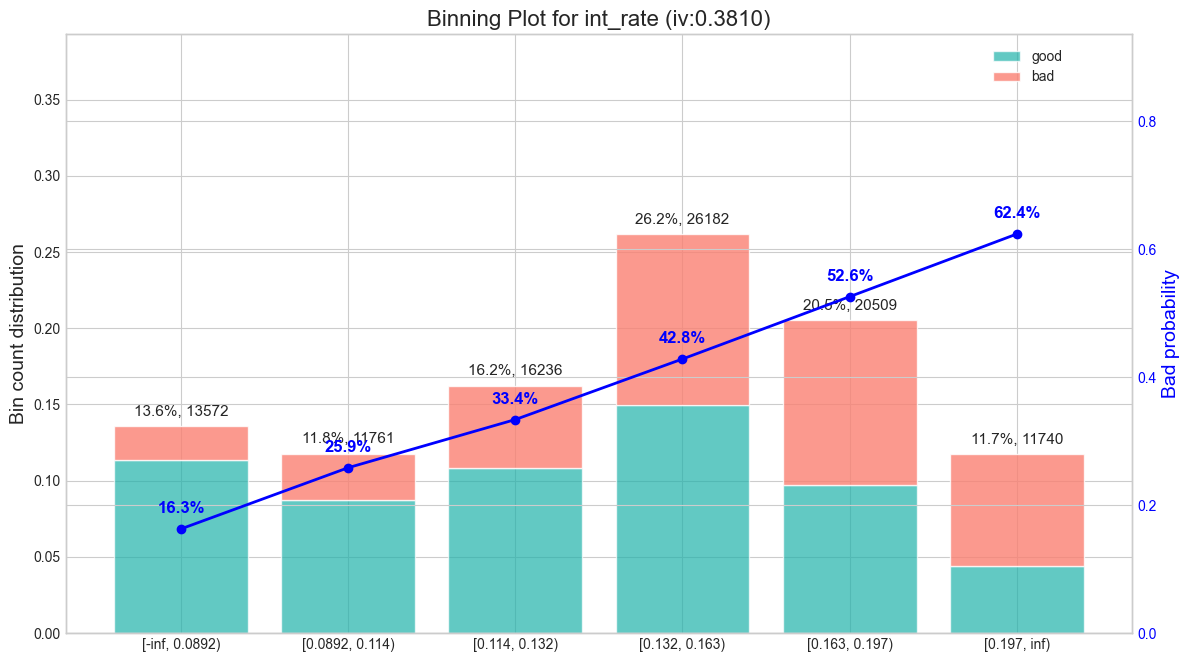

Feature Name: term
IV Score: 0.1920

WOE Table:


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,term,36.0,69544,0.69544,46589,22955,0.330072,0.302364
1,term,60.0,30456,0.30456,13411,17045,0.559643,-0.645247



Binning Cutoffs/Categories:
[36.0, 60.0]

Binning Visualization:


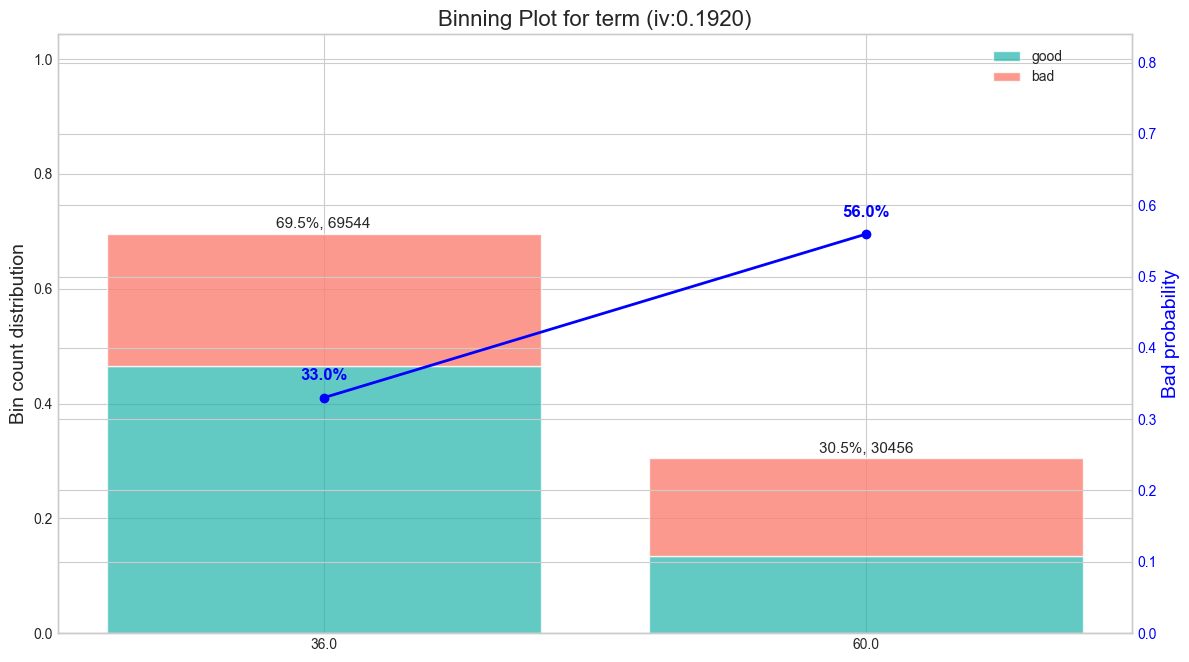

Feature Name: loan_to_inc_ratio
IV Score: 0.1211

WOE Table:


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,loan_to_inc_ratio,"[-inf, 0.0715)",7185,0.07185,5221,1964,0.273278,0.572241
1,loan_to_inc_ratio,"[0.0715, 0.164)",26041,0.26041,17670,8371,0.321435,0.341630
2,loan_to_inc_ratio,"[0.164, 0.233)",22041,0.22041,13939,8102,0.367565,0.137115
3,loan_to_inc_ratio,"[0.233, 0.296)",16522,0.16522,9430,7092,0.429216,-0.120536
4,loan_to_inc_ratio,"[0.296, 0.357)",13324,0.13324,6850,6474,0.485853,-0.349011
5,loan_to_inc_ratio,"[0.357, inf)",14887,0.14887,6890,7997,0.537147,-0.554460



Binning Cutoffs/Categories:
[-inf, np.float64(0.0715373046696186), np.float64(0.1640917956829071), np.float64(0.23336796462535858), np.float64(0.2961394488811493), np.float64(0.35684219002723694), inf]

Binning Visualization:


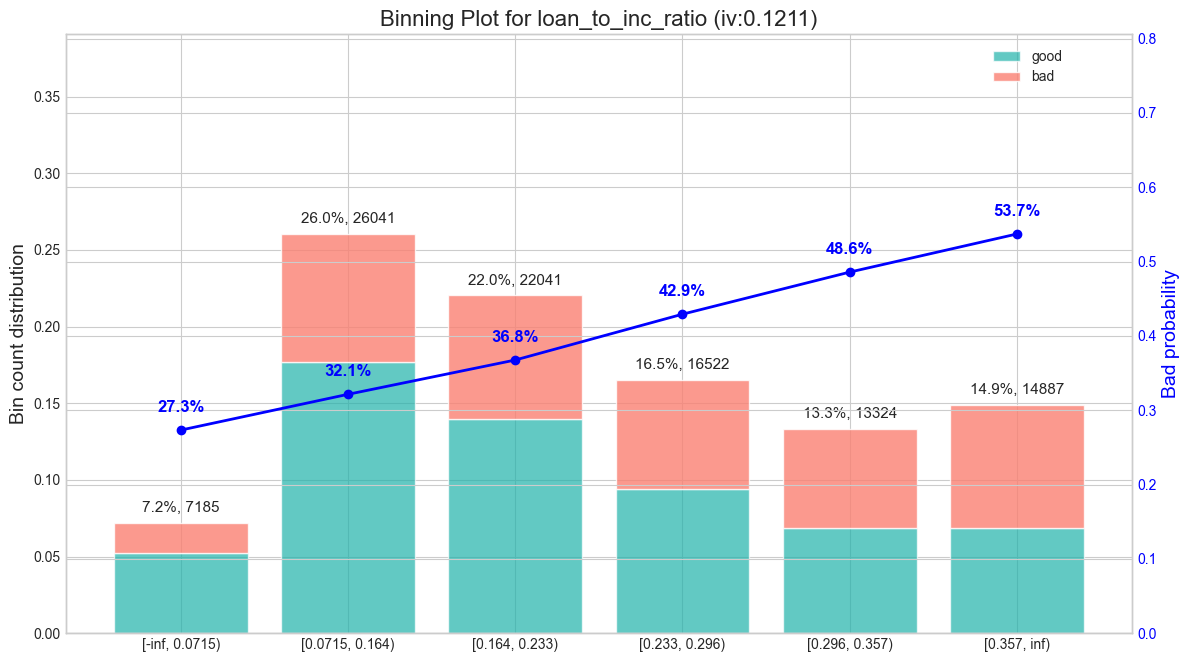

Feature Name: fico_range_high
IV Score: 0.1090

WOE Table:


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,fico_range_high,"[-inf, 676.5)",26893,0.26893,14023,12870,0.478545,-0.319665
1,fico_range_high,"[676.5, 686.5)",16183,0.16183,8928,7255,0.448279,-0.197964
2,fico_range_high,"[686.5, 701.5)",20584,0.20584,12105,8479,0.411898,-0.049439
3,fico_range_high,"[701.5, 711.5)",10420,0.10420,6520,3900,0.374232,0.108433
4,fico_range_high,"[711.5, 746.5)",18402,0.18402,12531,5871,0.319014,0.352715
5,fico_range_high,"[746.5, inf)",7518,0.07518,5893,1625,0.216081,0.882792



Binning Cutoffs/Categories:
[-inf, np.float64(676.5), np.float64(686.5), np.float64(701.5), np.float64(711.5), np.float64(746.5), inf]

Binning Visualization:


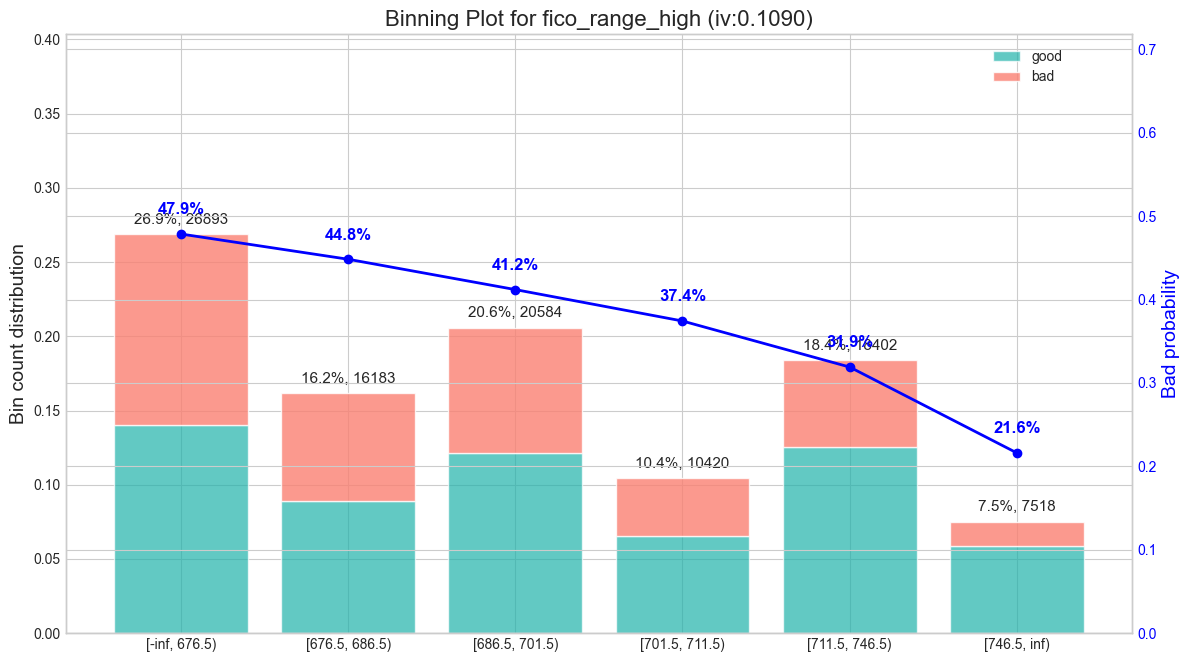

Feature Name: recent_acc_ratio
IV Score: 0.0666

WOE Table:


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,recent_acc_ratio,"[-inf, 0.0957)",31225,0.31225,20833,10392,0.332794,0.290037
1,recent_acc_ratio,"[0.0957, 0.131)",12182,0.12182,7843,4339,0.356140,0.186512
2,recent_acc_ratio,"[0.131, 0.179)",16104,0.16104,9761,6343,0.393846,0.025578
3,recent_acc_ratio,"[0.179, 0.275)",22104,0.22104,12306,9798,0.443246,-0.177556
4,recent_acc_ratio,"[0.275, 0.382)",10951,0.10951,5677,5274,0.481554,-0.331831
5,recent_acc_ratio,"[0.382, inf)",7434,0.07434,3580,3854,0.518362,-0.479214



Binning Cutoffs/Categories:
[-inf, np.float64(0.09569597244262695), np.float64(0.1310068666934967), np.float64(0.17902930825948715), np.float64(0.2754310369491577), np.float64(0.38165266811847687), inf]

Binning Visualization:


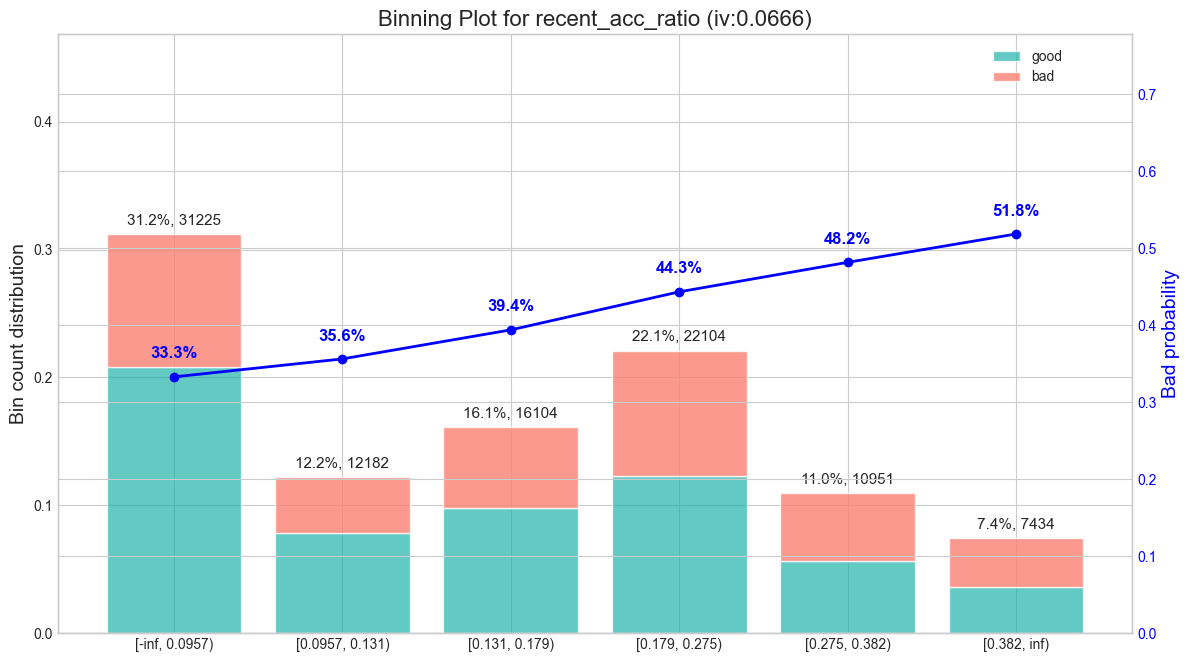

Feature Name: fico_div_dti
IV Score: 0.0657

WOE Table:


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,fico_div_dti,"[-inf, 22.238)",5005,0.05005,2342,2663,0.531968,-0.533913
1,fico_div_dti,"[22.238, 26.765)",11159,0.11159,5697,5462,0.489426,-0.363340
2,fico_div_dti,"[26.765, 30.795)",11357,0.11357,6205,5152,0.453597,-0.219495
3,fico_div_dti,"[30.795, 37.568)",17012,0.17012,9818,7194,0.422849,-0.094495
4,fico_div_dti,"[37.568, 66.015)",34964,0.34964,22009,12955,0.370510,0.124505
5,fico_div_dti,"[66.015, inf)",20503,0.20503,13929,6574,0.320612,0.345385



Binning Cutoffs/Categories:
[-inf, np.float64(22.23813819885254), np.float64(26.764591217041016), np.float64(30.79452896118164), np.float64(37.56833457946777), np.float64(66.01483917236328), inf]

Binning Visualization:


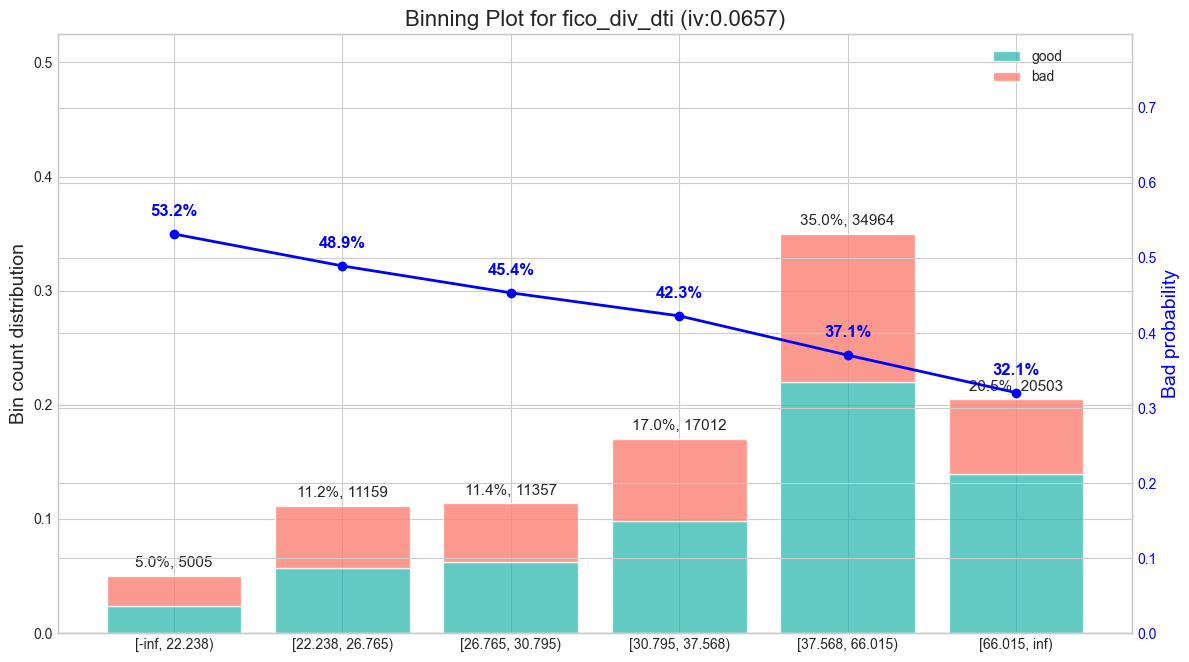

Feature Name: acc_open_past_24mths
IV Score: 0.0557

WOE Table:


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,acc_open_past_24mths,"[-inf, 2.5)",34848,0.34848,23051,11797,0.338513,0.264399
1,acc_open_past_24mths,"[2.5, 3.5)",14128,0.14128,8748,5380,0.380769,0.080672
2,acc_open_past_24mths,"[3.5, 4.5)",13394,0.13394,8011,5383,0.401859,-0.007895
3,acc_open_past_24mths,"[4.5, 5.5)",11116,0.11116,6336,4780,0.429966,-0.123658
4,acc_open_past_24mths,"[5.5, 7.5)",14844,0.14844,8068,6776,0.456447,-0.230946
5,acc_open_past_24mths,"[7.5, inf)",11670,0.11670,5786,5884,0.504156,-0.422261



Binning Cutoffs/Categories:
[-inf, np.float64(2.5), np.float64(3.5), np.float64(4.5), np.float64(5.5), np.float64(7.5), inf]

Binning Visualization:


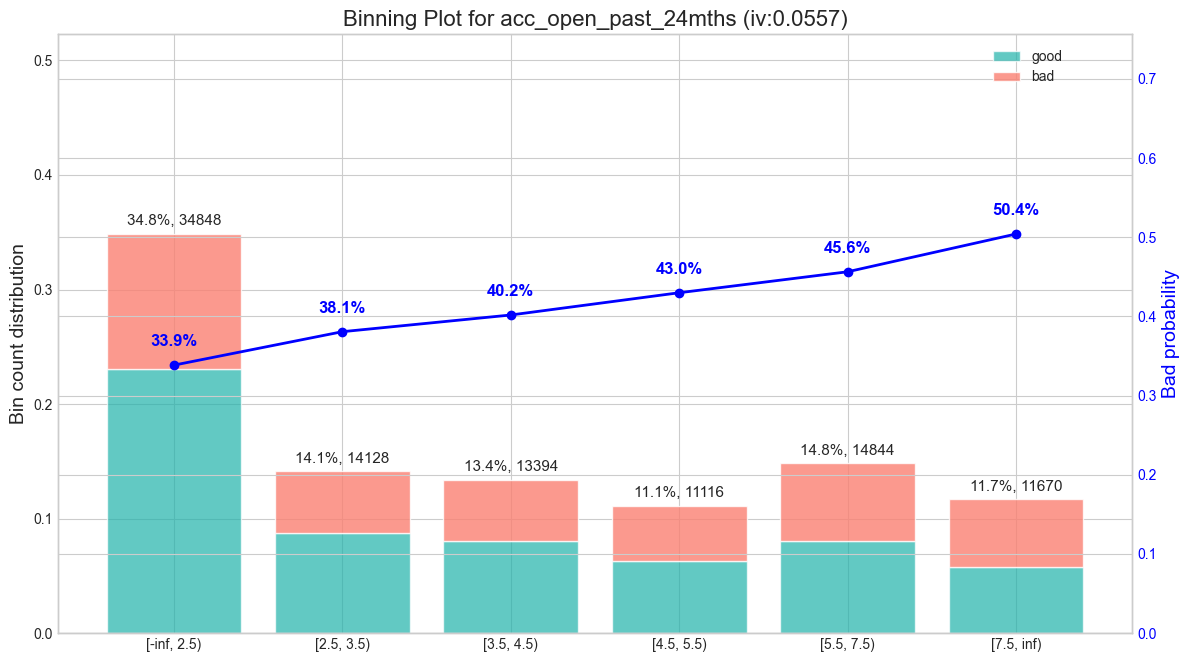

Feature Name: dti
IV Score: 0.0546

WOE Table:


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,dti,"[-inf, 5.035)",5003,0.05003,3482,1521,0.303918,0.422774
1,dti,"[5.035, 10.905)",16718,0.16718,11129,5589,0.334280,0.283289
2,dti,"[10.905, 18.225)",32393,0.32393,20300,12093,0.373306,0.112529
3,dti,"[18.225, 25.055)",27199,0.27199,15524,11675,0.429225,-0.120528
4,dti,"[25.055, 29.015)",10058,0.10058,5272,4786,0.475790,-0.308750
5,dti,"[29.015, inf)",8629,0.08629,4293,4336,0.502434,-0.415432



Binning Cutoffs/Categories:
[-inf, np.float64(5.0350000858306885), np.float64(10.904999732971191), np.float64(18.22499942779541), np.float64(25.054999351501465), np.float64(29.015000343322754), inf]

Binning Visualization:


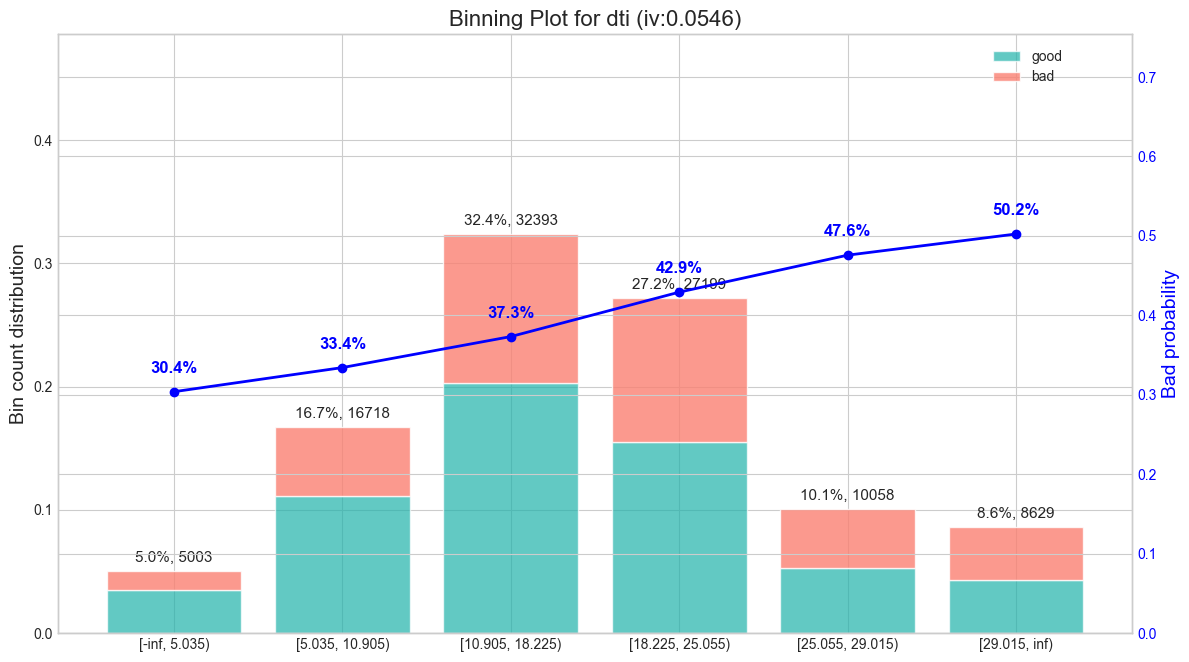

Feature Name: bc_open_to_buy
IV Score: 0.0424

WOE Table:


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,bc_open_to_buy,"[-inf, 170.5)",6856,0.06856,3439,3417,0.498323,-0.399047
1,bc_open_to_buy,"[170.5, 3315.5)",48628,0.48628,28193,20435,0.420221,-0.083641
2,bc_open_to_buy,"[3315.5, 9234.5)",22813,0.22813,13701,9112,0.399399,0.002411
3,bc_open_to_buy,"[9234.5, 18731.0)",11802,0.11802,7605,4197,0.355575,0.188971
4,bc_open_to_buy,"[18731.0, inf)",9901,0.09901,7062,2839,0.286688,0.505811



Binning Cutoffs/Categories:
[-inf, 170.5, 3315.5, 9234.5, 18731.0, inf]

Binning Visualization:


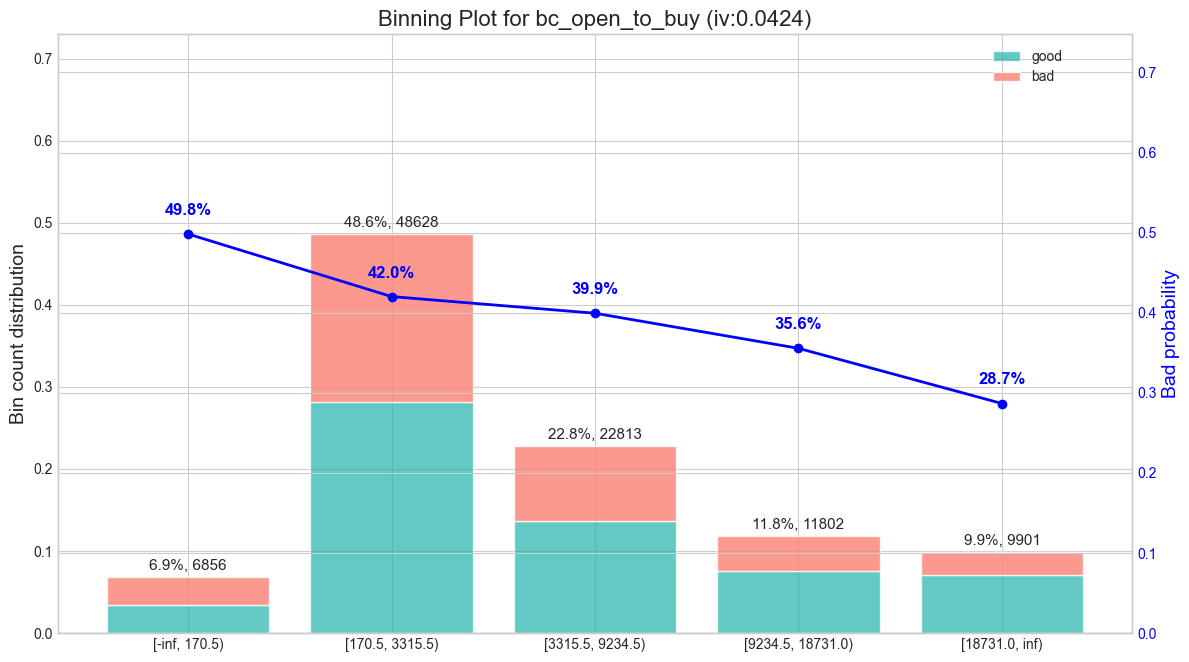

Feature Name: disposable_monthly_inc
IV Score: 0.0441

WOE Table:


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,disposable_monthly_inc,"[-inf, 3403.215)",26273,0.26273,14306,11967,0.455468,-0.226939
1,disposable_monthly_inc,"[3403.215, 4742.848)",24853,0.24853,14197,10656,0.428741,-0.118558
2,disposable_monthly_inc,"[4742.848, 5569.26)",12192,0.12192,7331,4861,0.398663,0.005403
3,disposable_monthly_inc,"[5569.26, 7858.048)",20816,0.20816,13310,7506,0.360564,0.167348
4,disposable_monthly_inc,"[7858.048, 9736.336)",7541,0.07541,5056,2485,0.329466,0.304838
5,disposable_monthly_inc,"[9736.336, inf)",8325,0.08325,5800,2525,0.303243,0.426152



Binning Cutoffs/Categories:
[-inf, np.float64(3403.215087890625), np.float64(4742.848388671875), np.float64(5569.260009765625), np.float64(7858.04833984375), np.float64(9736.33642578125), inf]

Binning Visualization:


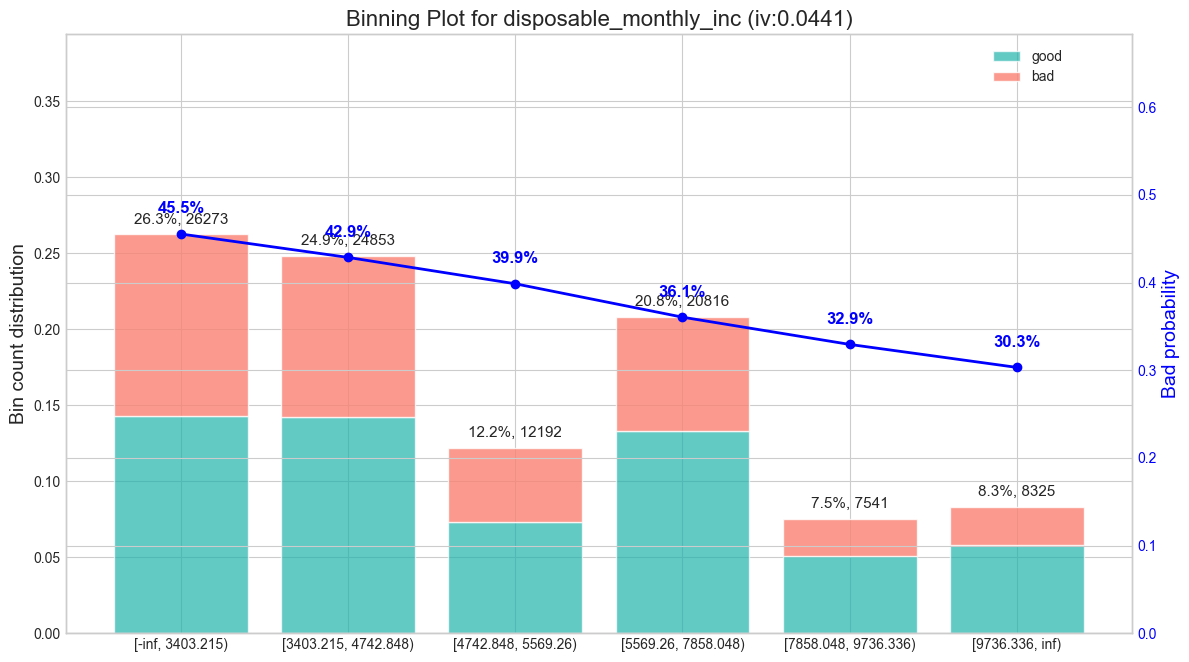

Feature Name: verification_status
IV Score: 0.0418

WOE Table:


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,verification_status,Not Verified,29366,0.29366,19826,9540,0.324848,0.326036
1,verification_status,Verified/Source Verified,70634,0.70634,40174,30460,0.431230,-0.128659



Binning Cutoffs/Categories:
['Not Verified', 'Verified/Source Verified']

Binning Visualization:


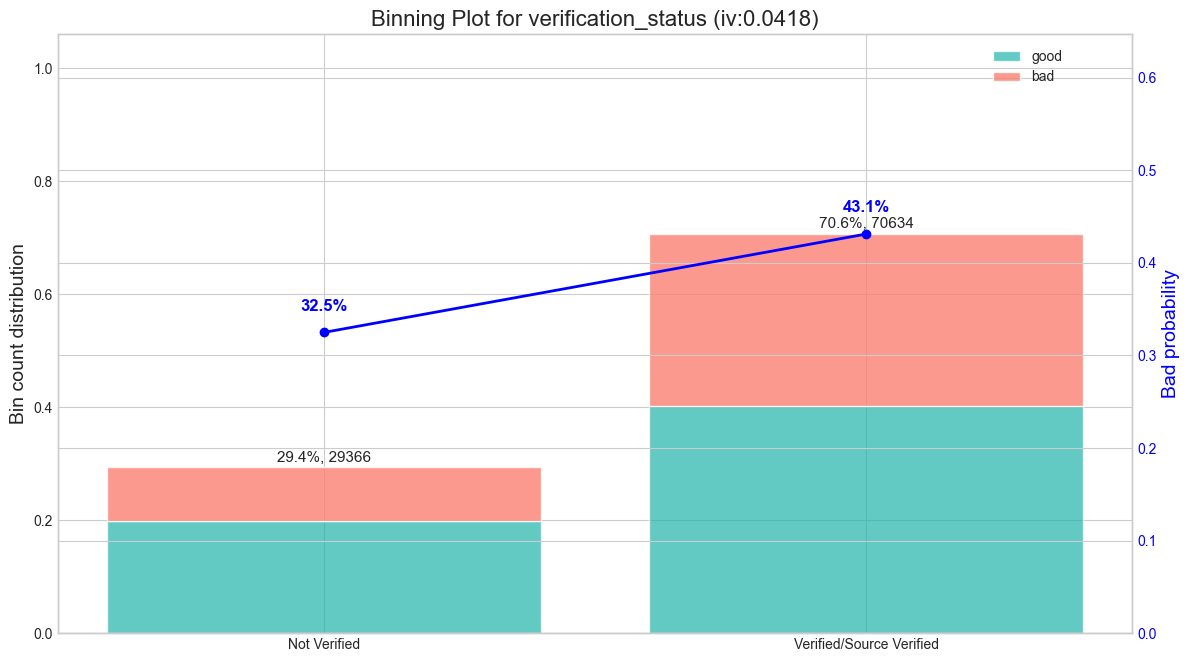

Feature Name: avg_cur_bal
IV Score: 0.0381

WOE Table:


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,avg_cur_bal,"[-inf, 214.0)",14732,0.14732,9301,5431,0.368619,0.132534
1,avg_cur_bal,"[214.0, 13057.5)",55375,0.55375,31222,24153,0.436163,-0.148751
2,avg_cur_bal,"[13057.5, 21542.5)",13238,0.13238,8131,5107,0.385746,0.059607
3,avg_cur_bal,"[21542.5, 27380.5)",5764,0.05764,3754,2010,0.348629,0.219222
4,avg_cur_bal,"[27380.5, 37061.5)",5364,0.05364,3622,1742,0.324664,0.326527
5,avg_cur_bal,"[37061.5, inf)",5527,0.05527,3970,1557,0.281618,0.530540



Binning Cutoffs/Categories:
[-inf, np.float64(214.0), np.float64(13057.5), np.float64(21542.5), np.float64(27380.5), np.float64(37061.5), inf]

Binning Visualization:


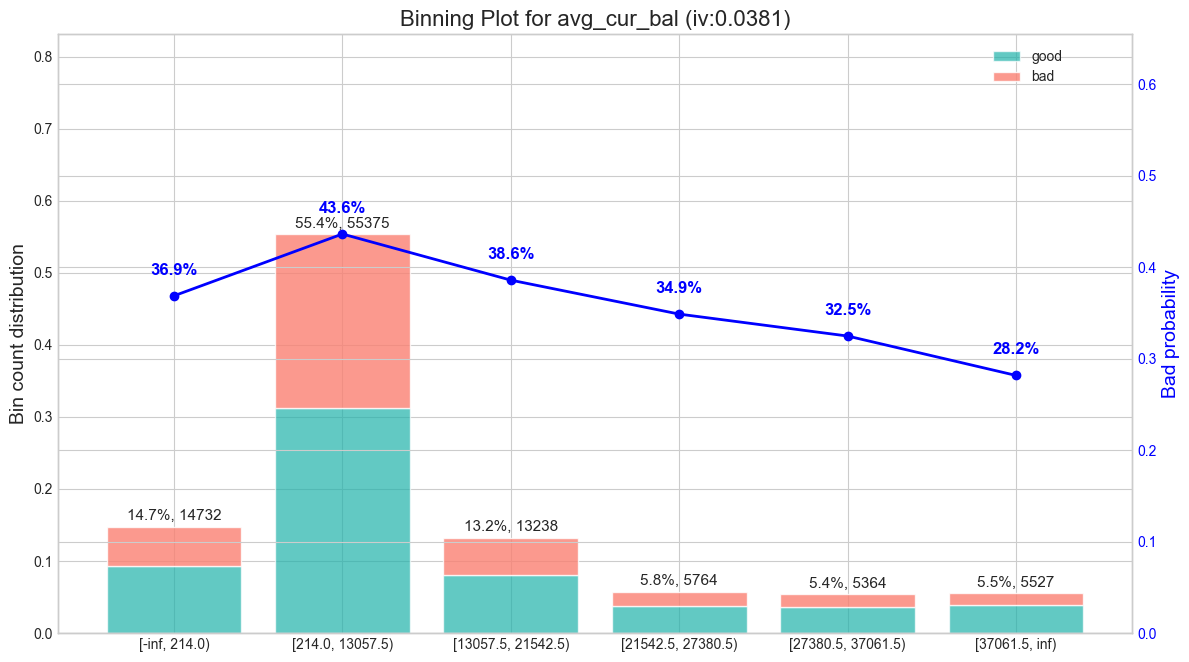

Feature Name: percent_bc_gt_75
IV Score: 0.0327

WOE Table:


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,percent_bc_gt_75,"[-inf, 15.6)",15903,0.15903,10613,5290,0.332610,0.290796
1,percent_bc_gt_75,"[15.6, 29.7)",8756,0.08756,5512,3244,0.370432,0.124655
2,percent_bc_gt_75,"[29.7, 52.3)",32979,0.32979,20367,12612,0.382410,0.073802
3,percent_bc_gt_75,"[52.3, 76.7)",17482,0.17482,9919,7563,0.432588,-0.134281
4,percent_bc_gt_75,"[76.7, 97.05)",5533,0.05533,2849,2684,0.484999,-0.345805
5,percent_bc_gt_75,"[97.05, inf)",19347,0.19347,10740,8607,0.444849,-0.184066



Binning Cutoffs/Categories:
[-inf, np.float64(15.599999904632568), np.float64(29.699999809265137), np.float64(52.29999923706055), np.float64(76.70000076293945), np.float64(97.04999923706055), inf]

Binning Visualization:


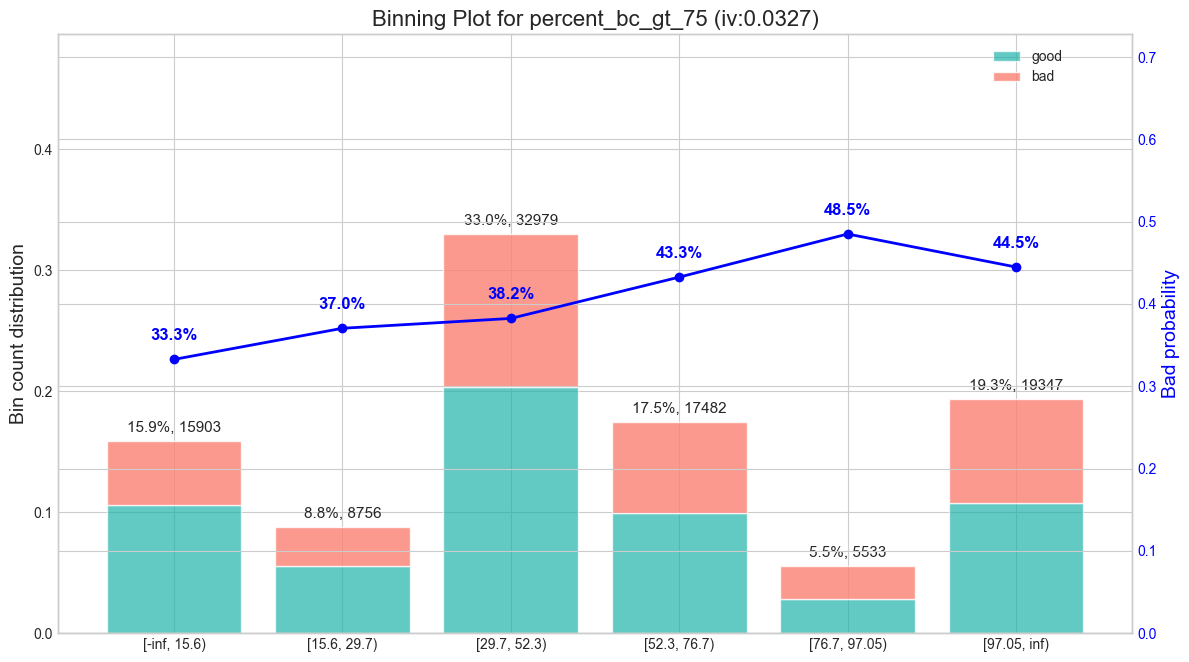

Feature Name: loan_amnt
IV Score: 0.0317

WOE Table:


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,loan_amnt,"[-inf, 7062.5)",20191,0.20191,13294,6897,0.341563,0.250761
1,loan_amnt,"[7062.5, 10012.5)",18420,0.18420,11670,6750,0.366422,0.142014
2,loan_amnt,"[10012.5, 11987.5)",5015,0.05015,2757,2258,0.450150,-0.205801
3,loan_amnt,"[11987.5, 12012.5)",5259,0.05259,3332,1927,0.366324,0.142143
4,loan_amnt,"[12012.5, 15012.5)",11987,0.11987,7165,4822,0.402227,-0.009446
5,loan_amnt,"[15012.5, inf)",39128,0.39128,21782,17346,0.443301,-0.177743



Binning Cutoffs/Categories:
[-inf, np.float64(7062.5), np.float64(10012.5), np.float64(11987.5), np.float64(12012.5), np.float64(15012.5), inf]

Binning Visualization:


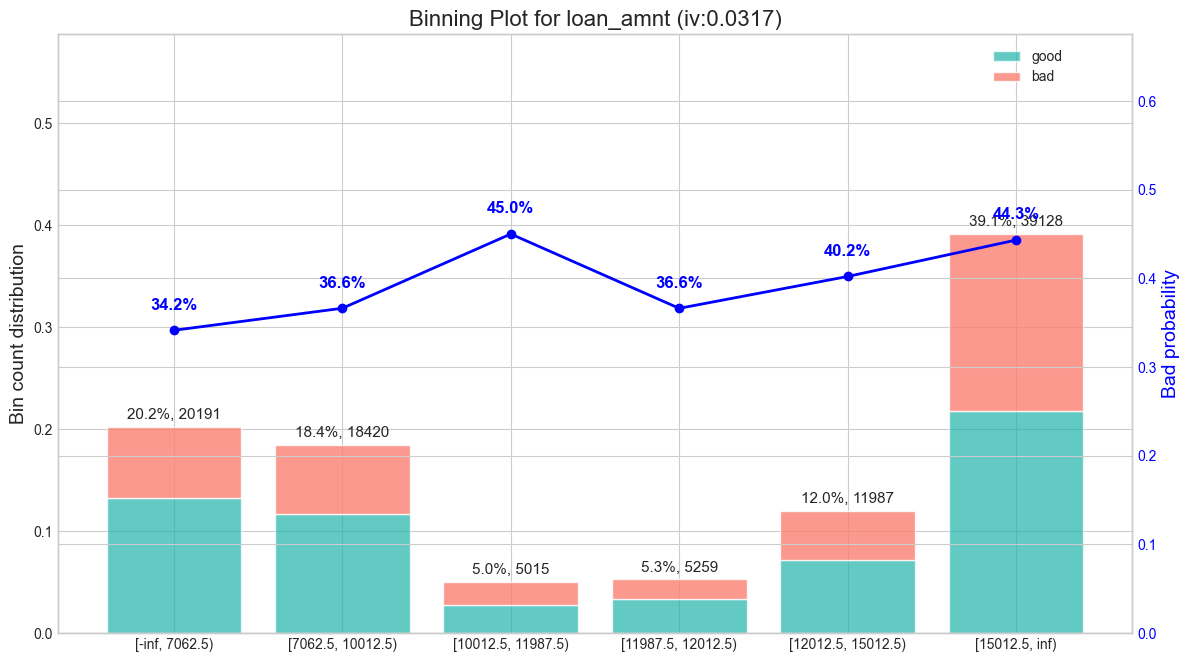

Feature Name: mo_sin_rcnt_tl
IV Score: 0.0309

WOE Table:


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,mo_sin_rcnt_tl,"[-inf, 1.5)",8939,0.08939,4777,4162,0.465544,-0.267648
1,mo_sin_rcnt_tl,"[1.5, 3.5)",18305,0.18305,10161,8144,0.444878,-0.184190
2,mo_sin_rcnt_tl,"[3.5, 8.5)",30842,0.30842,18191,12651,0.410171,-0.042274
3,mo_sin_rcnt_tl,"[8.5, 14.5)",16408,0.16408,10216,6192,0.377346,0.095232
4,mo_sin_rcnt_tl,"[14.5, 84.5)",10862,0.10862,7419,3443,0.316931,0.362236
5,mo_sin_rcnt_tl,"[84.5, inf)",14644,0.14644,9236,5408,0.369264,0.129764



Binning Cutoffs/Categories:
[-inf, np.float64(1.5), np.float64(3.5), np.float64(8.5), np.float64(14.5), np.float64(84.5), inf]

Binning Visualization:


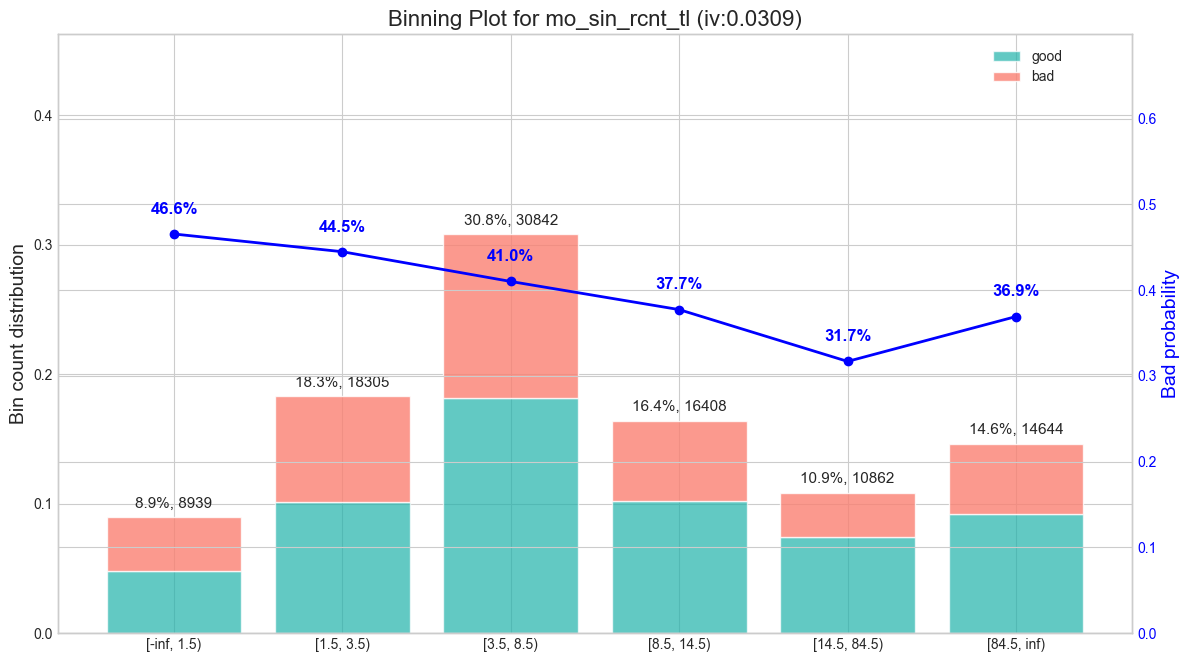

Feature Name: revol_util
IV Score: 0.0294

WOE Table:


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,revol_util,"[-inf, 0.183)",6376,0.06376,4469,1907,0.299012,0.446168
1,revol_util,"[0.183, 0.343)",11990,0.11990,7821,4169,0.347665,0.223671
2,revol_util,"[0.343, 0.468)",14658,0.14658,9125,5533,0.377439,0.094823
3,revol_util,"[0.468, 0.616)",21909,0.21909,13121,8788,0.401091,-0.004638
4,revol_util,"[0.616, 0.727)",16637,0.16637,9628,7009,0.421260,-0.087985
5,revol_util,"[0.727, inf)",28430,0.28430,15836,12594,0.442965,-0.176400



Binning Cutoffs/Categories:
[-inf, np.float64(0.1834999993443489), np.float64(0.3425000011920929), np.float64(0.4677000045776367), np.float64(0.6155000030994415), np.float64(0.7274999916553497), inf]

Binning Visualization:


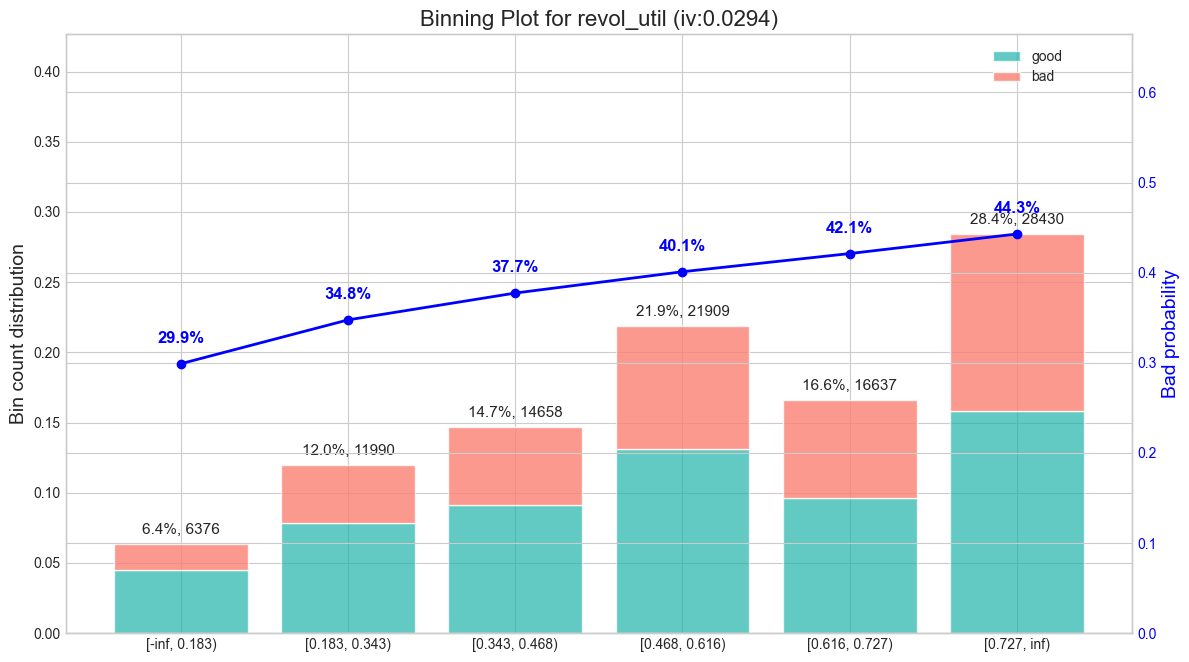

Feature Name: mths_since_recent_inq
IV Score: 0.0276

WOE Table:


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,mths_since_recent_inq,"[-inf, 1.5)",17082,0.17082,9275,7807,0.457002,-0.233163
1,mths_since_recent_inq,"[1.5, 2.5)",7408,0.07408,4154,3254,0.439187,-0.161278
2,mths_since_recent_inq,"[2.5, 4.5)",12428,0.12428,7133,5295,0.426014,-0.107496
3,mths_since_recent_inq,"[4.5, 8.5)",18542,0.18542,10985,7557,0.407534,-0.031409
4,mths_since_recent_inq,"[8.5, 17.5)",20427,0.20427,12646,7781,0.380893,0.080191
5,mths_since_recent_inq,"[17.5, inf)",24113,0.24113,15807,8306,0.344441,0.238010



Binning Cutoffs/Categories:
[-inf, np.float64(1.5), np.float64(2.5), np.float64(4.5), np.float64(8.5), np.float64(17.5), inf]

Binning Visualization:


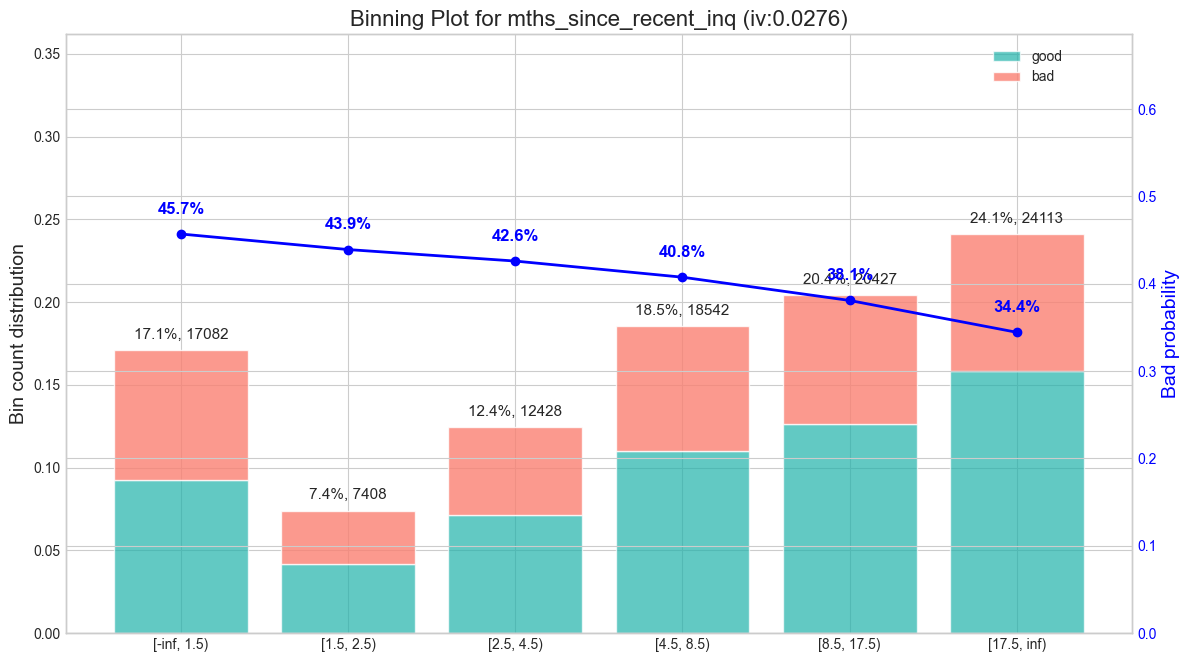

Feature Name: num_rev_tl_bal_gt_0
IV Score: 0.0243

WOE Table:


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,num_rev_tl_bal_gt_0,"[-inf, 0.5)",14770,0.14770,9318,5452,0.369093,0.130500
1,num_rev_tl_bal_gt_0,"[0.5, 3.5)",19130,0.19130,12322,6808,0.355855,0.187823
2,num_rev_tl_bal_gt_0,"[3.5, 5.5)",26115,0.26115,15848,10267,0.393127,0.028643
3,num_rev_tl_bal_gt_0,"[5.5, 7.5)",19560,0.19560,11422,8138,0.416028,-0.066468
4,num_rev_tl_bal_gt_0,"[7.5, 10.5)",14001,0.14001,7877,6124,0.437362,-0.153733
5,num_rev_tl_bal_gt_0,"[10.5, inf)",6424,0.06424,3213,3211,0.499767,-0.404842



Binning Cutoffs/Categories:
[-inf, np.float64(0.5), np.float64(3.5), np.float64(5.5), np.float64(7.5), np.float64(10.5), inf]

Binning Visualization:


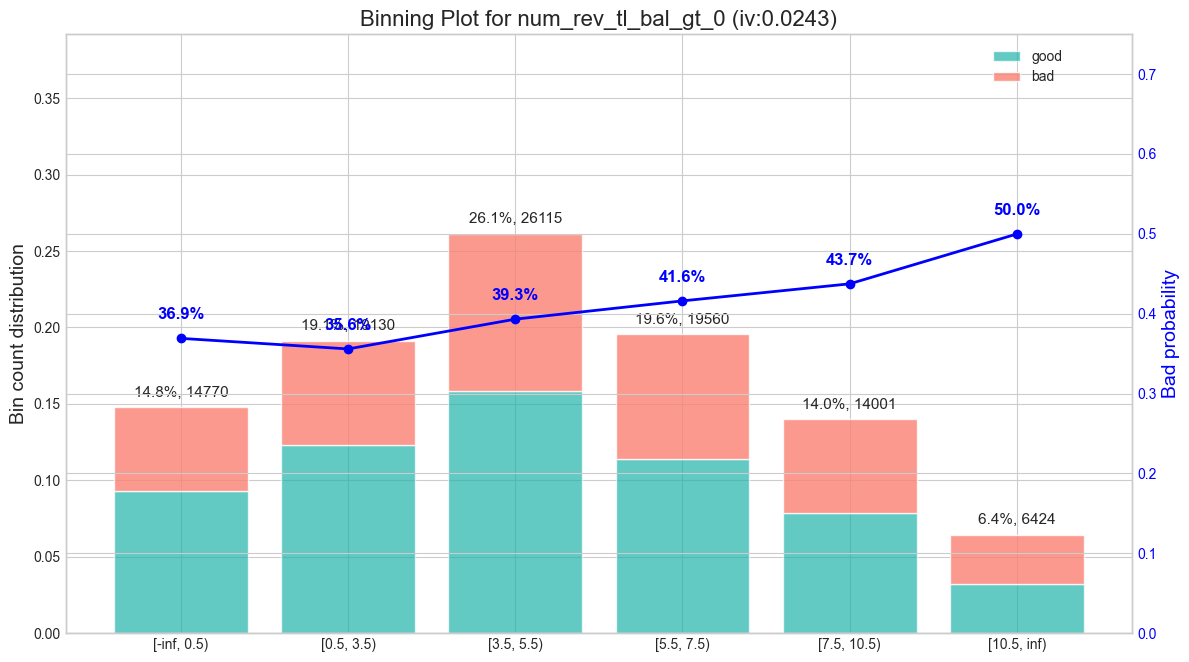

Feature Name: purpose
IV Score: 0.0232

WOE Table:


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,purpose,car,1100,0.01100,797,303,0.275000,0.561657
1,purpose,credit_card,21344,0.21344,13745,7599,0.356002,0.187193
2,purpose,debt_consolidation,59843,0.59843,34999,24844,0.415145,-0.062762
3,purpose,educational,71,0.00071,41,30,0.415493,-0.093090
4,purpose,home_improvement,5467,0.05467,3461,2006,0.366837,0.139950
5,purpose,house,499,0.00499,278,221,0.441884,-0.176007
6,purpose,major_purchase,1960,0.01960,1271,689,0.351276,0.206853
7,purpose,medical,992,0.00992,589,403,0.405746,-0.025975
8,purpose,moving,660,0.00660,370,290,0.438636,-0.161843
9,purpose,other,5226,0.05226,2958,2268,0.433888,-0.139850



Binning Cutoffs/Categories:
['car', 'credit_card', 'debt_consolidation', 'educational', 'home_improvement', 'house', 'major_purchase', 'medical', 'moving', 'other', 'renewable_energy', 'small_business', 'vacation', 'wedding']

Binning Visualization:


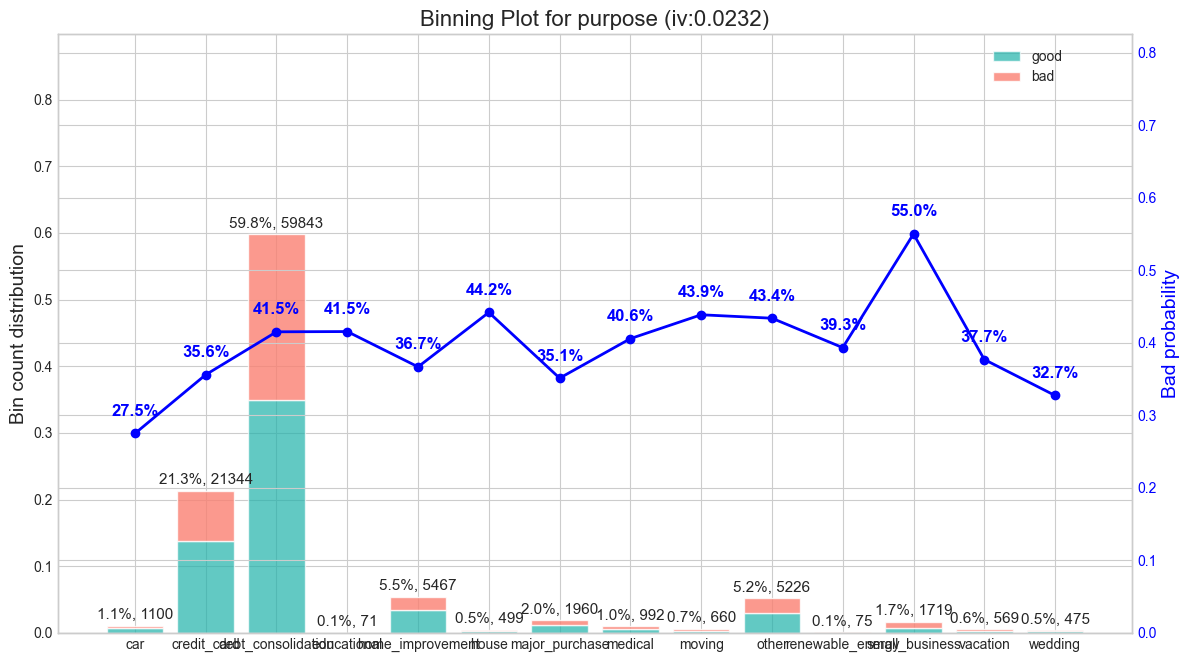

Feature Name: inq_last_6mths
IV Score: 0.0216

WOE Table:


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,inq_last_6mths,0.0,50068,0.50068,31616,18452,0.368529,0.133025
1,inq_last_6mths,1.0,28409,0.28409,16657,11752,0.413654,-0.056658
2,inq_last_6mths,2.0,13211,0.13211,7339,5872,0.444440,-0.182458
3,inq_last_6mths,3.0,5996,0.05996,3207,2789,0.465060,-0.265812
4,inq_last_6mths,4.0,2316,0.02316,1181,1135,0.489853,-0.365736



Binning Cutoffs/Categories:
[0.0, 1.0, 2.0, 3.0, 4.0]

Binning Visualization:


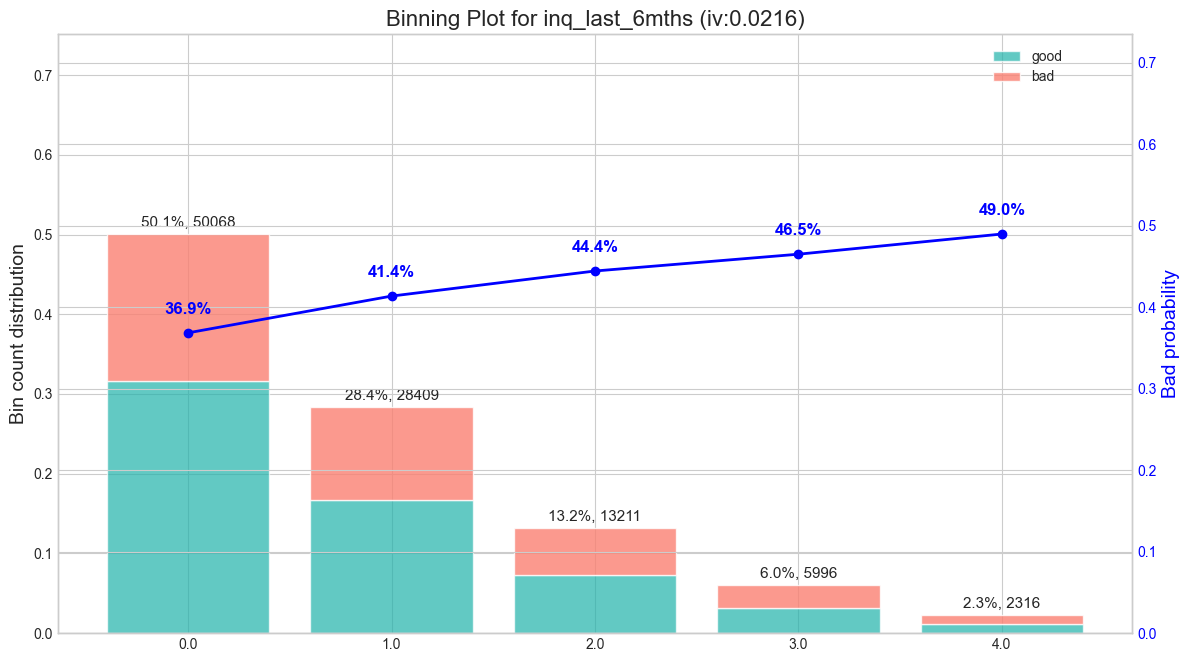

In [41]:

import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['axes.unicode_minus'] = False

def plot_binning_chart(woe_table, iv_score):

    feature_name = woe_table['variable'].iloc[0]

    df = woe_table.copy()
    df['bin_str'] = df['bin'].astype(str)
    total_obs = df['total'].sum()
    df['good_distr_total'] = df['good'] / total_obs
    df['bad_distr_total'] = df['bad'] / total_obs

    fig, ax1 = plt.subplots(figsize=(12, 7))

    ax1.bar(df['bin_str'], df['good_distr_total'], color='lightseagreen', alpha=0.7, label='good')
    ax1.bar(df['bin_str'], df['bad_distr_total'], bottom=df['good_distr_total'], color='salmon', alpha=0.8, label='bad')

    ax1.set_ylabel('Bin count distribution', fontsize=14)
    ax1.set_xlabel('')
    max_distr = df['total_distr'].max()
    ax1.set_ylim(0, max_distr * 1.5)
    ax2 = ax1.twinx()
    ax2.plot(df['bin_str'], df['bad_rate'], marker='o', color='blue', linewidth=2)
    ax2.set_ylabel('Bad probability', color='blue', fontsize=14)
    max_bad_rate = df['bad_rate'].max()
    ax2.set_ylim(0, max_bad_rate * 1.5)
    ax2.tick_params(axis='y', labelcolor='blue')

    for i, row in df.iterrows():
        ax2.text(i, row['bad_rate'] + 0.02, f"{row['bad_rate']:.1%}", color='blue', ha='center', va='bottom', fontsize=12, fontweight='bold')
        total_distr_val = row['total_distr']
        ax1.text(i, total_distr_val + 0.005, f"{total_distr_val:.1%}, {row['total']}", ha='center', va='bottom', fontsize=11)

    ax1.set_title(f"Binning Plot for {feature_name} (iv:{iv_score:.4f})", fontsize=16)
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

    plt.xticks(rotation=15, ha='right')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

print("\n--- Step 8: Displaying IV, WOE Table, and Visualization for Final Features ---")

for feature in final_selected_features:
    print("="*80)
    print(f"Feature Name: {feature}")
    iv_value = final_iv_df.loc[feature, 'IV']
    print(f"IV Score: {iv_value:.4f}")

    print("\nWOE Table:")
    current_woe_table = woe_tables[feature]
    display(current_woe_table)

    print("\nBinning Cutoffs/Categories:")
    print(final_bins[feature])

    print("\nBinning Visualization:")
    plot_binning_chart(current_woe_table, iv_value)
    print("="*80)

- bc_open_to_buy	IV:0.0508	WOE/坏账率不单调（中间有“驼峰”）。但IV值不错（>0.05）。
- verification_status	IV:0.0418	两个“已验证”类别的坏账率几乎一样，分箱不合理。IV值尚可。
- percent_bc_gt_75
- mo_sin_rcnt_rev_tl_op
- loan_amnt purpose
- num_rev_tl_bal_gt_0
- avg_cur_bal IV过低，分箱不稳定，直接剔除

--- 步骤 9: 开始手动修正指定特征并整合最终结果 ---
  -> 正在重新处理特征: 'bc_open_to_buy' ...
     ... 更新完成。新IV值为: 0.0424
  -> 正在重新处理特征: 'verification_status' ...
     ... 更新完成。新IV值为: 0.0418

最终确定的入模特征 (10个):
['int_rate', 'term', 'loan_to_inc_ratio', 'fico_range_high', 'recent_acc_ratio', 'fico_div_dti', 'acc_open_past_24mths', 'disposable_monthly_inc', 'bc_open_to_buy', 'verification_status']

--- 正在绘制修正后特征的可视化图表 ---

Binning Visualization for Feature: 'bc_open_to_buy'


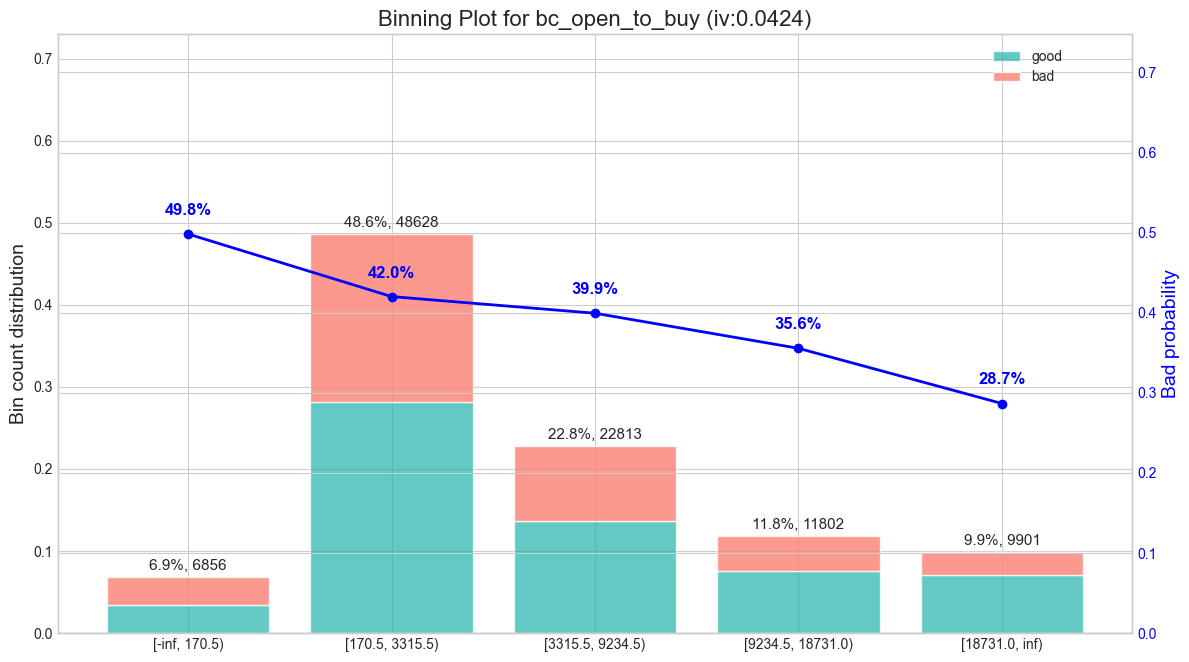


Binning Visualization for Feature: 'verification_status'


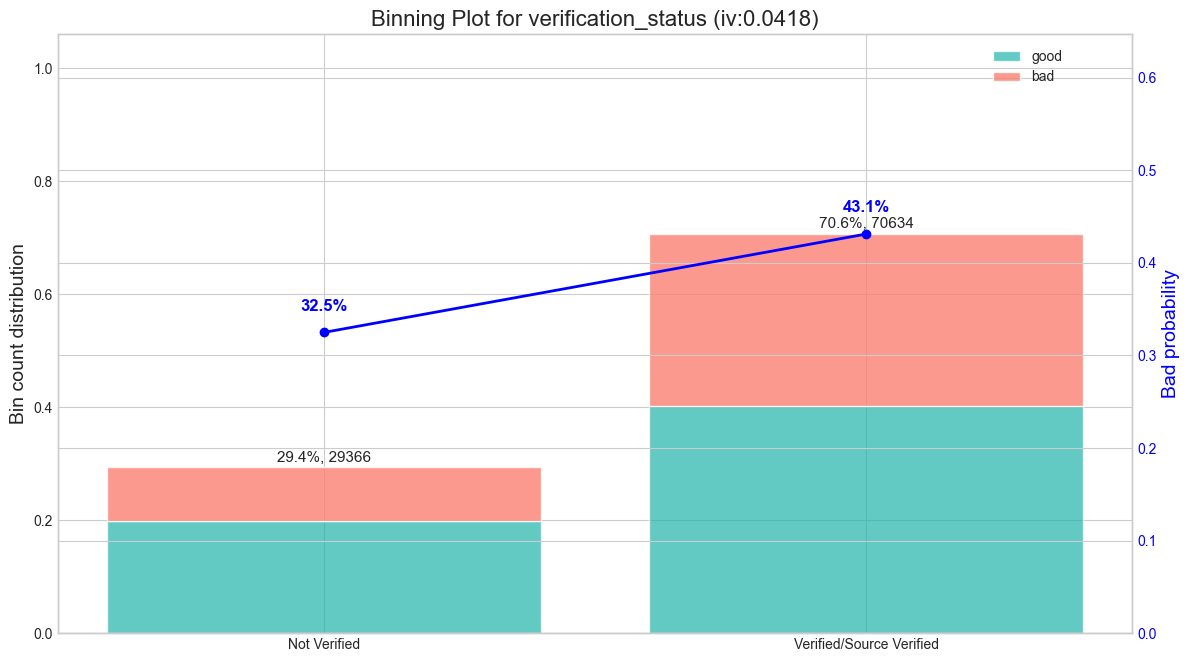


--- 生成最终12个入模特征的WOE Table ---
Feature Name: int_rate
IV Score: 0.3810


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,int_rate,"[-inf, 0.0892)",13572,0.13572,11361,2211,0.162872,1.231276
1,int_rate,"[0.0892, 0.114)",11761,0.11761,8720,3041,0.258524,0.647968
2,int_rate,"[0.114, 0.132)",16236,0.16236,10816,5420,0.333795,0.285466
3,int_rate,"[0.132, 0.163)",26182,0.26182,14964,11218,0.428443,-0.117337
4,int_rate,"[0.163, 0.197)",20509,0.20509,9723,10786,0.525891,-0.509220
5,int_rate,"[0.197, inf)",11740,0.11740,4416,7324,0.623807,-0.911387


Feature Name: term
IV Score: 0.1920


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,term,36.0,69544,0.69544,46589,22955,0.330072,0.302364
1,term,60.0,30456,0.30456,13411,17045,0.559643,-0.645247


Feature Name: loan_to_inc_ratio
IV Score: 0.1211


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,loan_to_inc_ratio,"[-inf, 0.0715)",7185,0.07185,5221,1964,0.273278,0.572241
1,loan_to_inc_ratio,"[0.0715, 0.164)",26041,0.26041,17670,8371,0.321435,0.341630
2,loan_to_inc_ratio,"[0.164, 0.233)",22041,0.22041,13939,8102,0.367565,0.137115
3,loan_to_inc_ratio,"[0.233, 0.296)",16522,0.16522,9430,7092,0.429216,-0.120536
4,loan_to_inc_ratio,"[0.296, 0.357)",13324,0.13324,6850,6474,0.485853,-0.349011
5,loan_to_inc_ratio,"[0.357, inf)",14887,0.14887,6890,7997,0.537147,-0.554460


Feature Name: fico_range_high
IV Score: 0.1090


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,fico_range_high,"[-inf, 676.5)",26893,0.26893,14023,12870,0.478545,-0.319665
1,fico_range_high,"[676.5, 686.5)",16183,0.16183,8928,7255,0.448279,-0.197964
2,fico_range_high,"[686.5, 701.5)",20584,0.20584,12105,8479,0.411898,-0.049439
3,fico_range_high,"[701.5, 711.5)",10420,0.10420,6520,3900,0.374232,0.108433
4,fico_range_high,"[711.5, 746.5)",18402,0.18402,12531,5871,0.319014,0.352715
5,fico_range_high,"[746.5, inf)",7518,0.07518,5893,1625,0.216081,0.882792


Feature Name: recent_acc_ratio
IV Score: 0.0666


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,recent_acc_ratio,"[-inf, 0.0957)",31225,0.31225,20833,10392,0.332794,0.290037
1,recent_acc_ratio,"[0.0957, 0.131)",12182,0.12182,7843,4339,0.356140,0.186512
2,recent_acc_ratio,"[0.131, 0.179)",16104,0.16104,9761,6343,0.393846,0.025578
3,recent_acc_ratio,"[0.179, 0.275)",22104,0.22104,12306,9798,0.443246,-0.177556
4,recent_acc_ratio,"[0.275, 0.382)",10951,0.10951,5677,5274,0.481554,-0.331831
5,recent_acc_ratio,"[0.382, inf)",7434,0.07434,3580,3854,0.518362,-0.479214


Feature Name: fico_div_dti
IV Score: 0.0657


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,fico_div_dti,"[-inf, 22.238)",5005,0.05005,2342,2663,0.531968,-0.533913
1,fico_div_dti,"[22.238, 26.765)",11159,0.11159,5697,5462,0.489426,-0.363340
2,fico_div_dti,"[26.765, 30.795)",11357,0.11357,6205,5152,0.453597,-0.219495
3,fico_div_dti,"[30.795, 37.568)",17012,0.17012,9818,7194,0.422849,-0.094495
4,fico_div_dti,"[37.568, 66.015)",34964,0.34964,22009,12955,0.370510,0.124505
5,fico_div_dti,"[66.015, inf)",20503,0.20503,13929,6574,0.320612,0.345385


Feature Name: acc_open_past_24mths
IV Score: 0.0557


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,acc_open_past_24mths,"[-inf, 2.5)",34848,0.34848,23051,11797,0.338513,0.264399
1,acc_open_past_24mths,"[2.5, 3.5)",14128,0.14128,8748,5380,0.380769,0.080672
2,acc_open_past_24mths,"[3.5, 4.5)",13394,0.13394,8011,5383,0.401859,-0.007895
3,acc_open_past_24mths,"[4.5, 5.5)",11116,0.11116,6336,4780,0.429966,-0.123658
4,acc_open_past_24mths,"[5.5, 7.5)",14844,0.14844,8068,6776,0.456447,-0.230946
5,acc_open_past_24mths,"[7.5, inf)",11670,0.11670,5786,5884,0.504156,-0.422261


Feature Name: disposable_monthly_inc
IV Score: 0.0441


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,disposable_monthly_inc,"[-inf, 3403.215)",26273,0.26273,14306,11967,0.455468,-0.226939
1,disposable_monthly_inc,"[3403.215, 4742.848)",24853,0.24853,14197,10656,0.428741,-0.118558
2,disposable_monthly_inc,"[4742.848, 5569.26)",12192,0.12192,7331,4861,0.398663,0.005403
3,disposable_monthly_inc,"[5569.26, 7858.048)",20816,0.20816,13310,7506,0.360564,0.167348
4,disposable_monthly_inc,"[7858.048, 9736.336)",7541,0.07541,5056,2485,0.329466,0.304838
5,disposable_monthly_inc,"[9736.336, inf)",8325,0.08325,5800,2525,0.303243,0.426152


Feature Name: bc_open_to_buy
IV Score: 0.0424


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,bc_open_to_buy,"[-inf, 170.5)",6856,0.06856,3439,3417,0.498323,-0.399047
1,bc_open_to_buy,"[170.5, 3315.5)",48628,0.48628,28193,20435,0.420221,-0.083641
2,bc_open_to_buy,"[3315.5, 9234.5)",22813,0.22813,13701,9112,0.399399,0.002411
3,bc_open_to_buy,"[9234.5, 18731.0)",11802,0.11802,7605,4197,0.355575,0.188971
4,bc_open_to_buy,"[18731.0, inf)",9901,0.09901,7062,2839,0.286688,0.505811


Feature Name: verification_status
IV Score: 0.0418


,variable,bin,total,total_distr,good,bad,bad_rate,woe
0,verification_status,Not Verified,29366,0.29366,19826,9540,0.324848,0.326036
1,verification_status,Verified/Source Verified,70634,0.70634,40174,30460,0.431230,-0.128659


In [47]:

print("--- 步骤 9: 开始手动修正指定特征并整合最终结果 ---")

manual_bins_override = {
    'bc_open_to_buy': [-np.inf, 170.5, 3315.5, 9234.5, 18731.0, np.inf],
    'verification_status': {
        'Verified': 'Verified/Source Verified',
        'Source Verified': 'Verified/Source Verified',
        'Not Verified': 'Not Verified'
    }
}

features_to_reprocess = ['bc_open_to_buy', 'verification_status']

for feature in features_to_reprocess:
    print(f"  -> 正在重新处理特征: '{feature}' ...")
    rule = manual_bins_override[feature]

    if isinstance(rule, list):
        binned_col = pd.cut(df_engineered[feature], bins=rule, right=False, duplicates='drop')
        temp_df = pd.DataFrame({feature: binned_col, 'Y': df_engineered['Y']})
        iv, woe_table = calculate_woe_iv(temp_df, feature, 'Y')
    elif isinstance(rule, dict):
        mapped_col = df_engineered[feature].map(rule)
        temp_df = pd.DataFrame({feature: mapped_col, 'Y': df_engineered['Y']})
        iv, woe_table = calculate_woe_iv(temp_df, feature, 'Y')

    if woe_table is not None:
        woe_tables[feature] = woe_table
        final_iv_df.loc[feature, 'IV'] = iv
        print(f"     ... 更新完成。新IV值为: {iv:.4f}")

final_model_features = [
    'int_rate',
    'term',
    'loan_to_inc_ratio',
    'fico_range_high',
    'recent_acc_ratio',
    'fico_div_dti',
    'acc_open_past_24mths',
    'disposable_monthly_inc',
    'bc_open_to_buy',
    'verification_status'
]


print(f"\n最终确定的入模特征 ({len(final_model_features)}个):")
print(final_model_features)

print("\n--- 正在绘制修正后特征的可视化图表 ---")
for feature in features_to_reprocess:
    print(f"\nBinning Visualization for Feature: '{feature}'")
    iv_value = final_iv_df.loc[feature, 'IV']
    plot_binning_chart(woe_tables[feature], iv_value)

print("\n--- 生成最终12个入模特征的WOE Table ---")
for feature in final_model_features:
    print("="*80)
    print(f"Feature Name: {feature}")
    print(f"IV Score: {final_iv_df.loc[feature, 'IV']:.4f}")
    display(woe_tables[feature])
    print("="*80)

## 4. 模型训练

逻辑回归模型

--- 步骤 10: 开始进行模型训练与评估 ---
数据集划分完成: 训练集 70000 | 测试集 30000

已定义修正版的WOE转换函数。
WOE转换完成。
转换后 'term' 列预览:
term
 0.302364    48610
-0.645247    21390
Name: count, dtype: int64

逻辑回归模型重新训练完成。

--- 模型性能评估 (修正后) ---
训练集 AUC: 0.6984
测试集 AUC: 0.6946
训练集 KS: 0.2907
测试集 KS: 0.2856


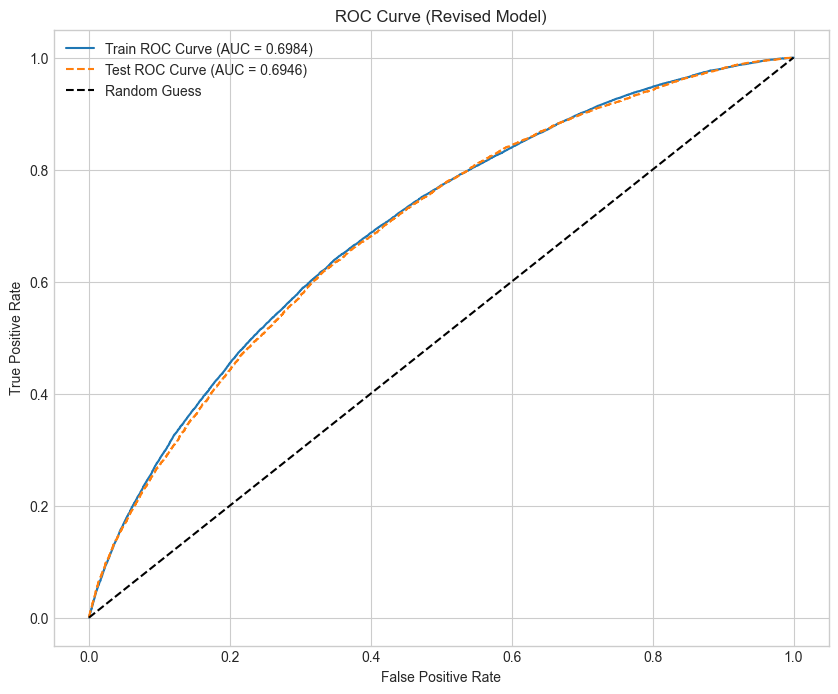


--- 模型变量系数 (修正后) ---


,Feature,Coefficient
9,verification_status,-0.077150
3,fico_range_high,-0.248013
5,fico_div_dti,-0.284455
4,recent_acc_ratio,-0.364849
2,loan_to_inc_ratio,-0.387303
6,acc_open_past_24mths,-0.424485
8,bc_open_to_buy,-0.442082
0,int_rate,-0.578458
1,term,-0.619896
7,disposable_monthly_inc,-0.671466


In [50]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("--- 步骤 10: 开始进行模型训练与评估 ---")

X_raw = df_engineered[final_model_features]
y = df_engineered['Y']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.3, random_state=42, stratify=y
)
print(f"数据集划分完成: 训练集 {len(X_train_raw)} | 测试集 {len(X_test_raw)}")

def transform_woe_revised(df_raw, woe_tables, final_bins):
    df_woe = pd.DataFrame(index=df_raw.index)

    for feature in df_raw.columns:
        woe_map_df = woe_tables[feature]
        woe_map = woe_map_df.set_index('bin')['woe'].to_dict()

        if feature in ['term'] or (df_raw[feature].dtype != 'object' and df_raw[feature].nunique() < 10):
            binned_series = df_raw[feature]

        elif df_raw[feature].dtype != 'object':
            bins_rule = final_bins[feature]
            binned_series = pd.cut(df_raw[feature], bins=bins_rule, right=False, duplicates='drop')

        else:
            binned_series = df_raw[feature]
            if feature in manual_bins_override and isinstance(manual_bins_override.get(feature), dict):
                binned_series = binned_series.map(manual_bins_override[feature])

        woe_series = binned_series.map(woe_map)

        if woe_series.isnull().any():
            woe_series.fillna(0, inplace=True)

        df_woe[feature] = woe_series

    return df_woe

print("\n已定义修正版的WOE转换函数。")

X_train_woe = transform_woe_revised(X_train_raw, woe_tables, final_bins)
X_test_woe = transform_woe_revised(X_test_raw, woe_tables, final_bins)
print("WOE转换完成。")
print("转换后 'term' 列预览:")
print(X_train_woe['term'].value_counts())

log_reg = LogisticRegression(random_state=42, class_weight='balanced', C=1.0, solver='liblinear')
log_reg.fit(X_train_woe, y_train)
print("\n逻辑回归模型重新训练完成。")

y_train_pred_proba = log_reg.predict_proba(X_train_woe)[:, 1]
y_test_pred_proba = log_reg.predict_proba(X_test_woe)[:, 1]

train_auc = roc_auc_score(y_train, y_train_pred_proba)
test_auc = roc_auc_score(y_test, y_test_pred_proba)
train_ks = calculate_ks(y_train, y_train_pred_proba)
test_ks = calculate_ks(y_test, y_test_pred_proba)

print("\n--- 模型性能评估 (修正后) ---")
print(f"训练集 AUC: {train_auc:.4f}")
print(f"测试集 AUC: {test_auc:.4f}")
print(f"训练集 KS: {train_ks:.4f}")
print(f"测试集 KS: {test_ks:.4f}")

plt.figure(figsize=(10, 8))
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)
plt.plot(fpr_train, tpr_train, label=f'Train ROC Curve (AUC = {train_auc:.4f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC Curve (AUC = {test_auc:.4f})', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve (Revised Model)')
plt.legend(); plt.grid(True); plt.show()

print("\n--- 模型变量系数 (修正后) ---")
coefficients = pd.DataFrame({
    'Feature': X_train_woe.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
display(coefficients)

## 5. 模型评分卡转换

In [52]:

import pandas as pd
import numpy as np

print("--- 步骤 11: 开始进行评分卡转换 ---")

base_score = 600
base_odds = 19
pdo = 20

factor = pdo / np.log(2)
offset = base_score - factor * np.log(base_odds)

print(f"\n评分卡参数计算完成:")
print(f"  - Factor (斜率): {factor:.4f}")
print(f"  - Offset (截距): {offset:.4f}")

intercept = log_reg.intercept_[0]
coeffs = log_reg.coef_[0]

feature_coeffs = pd.DataFrame(coeffs, index=X_train_woe.columns, columns=['Coefficient'])

scorecard = []
n_features = len(feature_coeffs)

for feature, coeff in feature_coeffs.iterrows():
    woe_table = woe_tables[feature]
    for index, row in woe_table.iterrows():
        woe_value = row['woe']
        bin_value = row['bin']
        bin_score = - (woe_value * coeff.iloc[0] + intercept / n_features) * factor
        scorecard.append({
            'Feature': feature,
            'Bin': bin_value,
            'Score': np.round(bin_score)
        })

final_scorecard = pd.DataFrame(scorecard)

print("\n--- 最终标准评分卡生成完毕 ---")
pd.set_option('display.max_rows', None)
display(final_scorecard)

base_points = offset - (intercept / n_features * factor * n_features)
print(f"\n评分卡基础分 (Base Points): {base_points:.0f}")
print("注：总分 = 基础分 + 所有特征对应分箱的得分")

print("\n--- 评分计算示例 ---")
sample_applicant = X_test_raw.iloc[[100]]
print("示例申请人原始数据:")
display(sample_applicant)

total_score = base_points
print("\n得分详情:")
for feature in sample_applicant.columns:
    value = sample_applicant[feature].iloc[0]
    feature_card = final_scorecard[final_scorecard['Feature'] == feature]
    matched_score = 0

    if isinstance(feature_card['Bin'].iloc[0], pd.Interval):
        for _, row in feature_card.iterrows():
            if value in row['Bin']:
                matched_score = row['Score']
                print(f"  - 特征 '{feature}' 的值为 {value:.2f}, 落在分箱 {row['Bin']} 中, 得分: {matched_score:.0f}")
                break
    else:
        bin_value = value
        if feature in manual_bins_override and isinstance(manual_bins_override.get(feature), dict):
            bin_value = manual_bins_override[feature].get(value, value)
        score_row = feature_card[feature_card['Bin'] == bin_value]
        if not score_row.empty:
            matched_score = score_row['Score'].iloc[0]
            print(f"  - 特征 '{feature}' 的值为 '{value}', 属于类别 '{bin_value}', 得分: {matched_score:.0f}")

    total_score += matched_score

print(f"\n示例申请人总得分: {total_score:.0f}")

--- 步骤 11: 开始进行评分卡转换 ---

评分卡参数计算完成:
  - Factor (斜率): 28.8539
  - Offset (截距): 515.0414

--- 最终标准评分卡生成完毕 ---


,Feature,Bin,Score
0,int_rate,"[-inf, 0.0892)",21.0
1,int_rate,"[0.0892, 0.114)",11.0
2,int_rate,"[0.114, 0.132)",5.0
3,int_rate,"[0.132, 0.163)",-2.0
4,int_rate,"[0.163, 0.197)",-8.0
5,int_rate,"[0.197, inf)",-15.0
6,term,36.0,5.0
7,term,60.0,-12.0
8,loan_to_inc_ratio,"[-inf, 0.0715)",6.0
9,loan_to_inc_ratio,"[0.0715, 0.164)",4.0



评分卡基础分 (Base Points): 515
注：总分 = 基础分 + 所有特征对应分箱的得分

--- 评分计算示例 ---
示例申请人原始数据:


,int_rate,term,loan_to_inc_ratio,fico_range_high,recent_acc_ratio,fico_div_dti,acc_open_past_24mths,disposable_monthly_inc,bc_open_to_buy,verification_status
54364,0.1114,36.0,0.089286,704.0,0.052632,45.390071,1.0,4502.636667,1058.0,Not Verified



得分详情:
  - 特征 'int_rate' 的值为 0.11, 落在分箱 [0.0892, 0.114) 中, 得分: 11
  - 特征 'term' 的值为 '36.0', 属于类别 '36.0', 得分: 5
  - 特征 'loan_to_inc_ratio' 的值为 0.09, 落在分箱 [0.0715, 0.164) 中, 得分: 4
  - 特征 'fico_range_high' 的值为 704.00, 落在分箱 [701.5, 711.5) 中, 得分: 1
  - 特征 'recent_acc_ratio' 的值为 0.05, 落在分箱 [-inf, 0.0957) 中, 得分: 3
  - 特征 'fico_div_dti' 的值为 45.39, 落在分箱 [37.568, 66.015) 中, 得分: 1
  - 特征 'acc_open_past_24mths' 的值为 1.00, 落在分箱 [-inf, 2.5) 中, 得分: 3
  - 特征 'disposable_monthly_inc' 的值为 4502.64, 落在分箱 [3403.215, 4742.848) 中, 得分: -2
  - 特征 'bc_open_to_buy' 的值为 1058.00, 落在分箱 [170.5, 3315.5) 中, 得分: -1
  - 特征 'verification_status' 的值为 'Not Verified', 属于类别 'Not Verified', 得分: 1

示例申请人总得分: 541


## 7. 模型评价与检验

In [55]:

import pandas as pd
import numpy as np

print("--- 开始基于最终评分卡计算分数并评估群体稳定性(PSI) ---")

def calculate_total_score(df_raw, final_scorecard, base_points, final_bins, manual_bins_override):
    total_scores = pd.Series(base_points, index=df_raw.index, dtype=float)

    for feature in df_raw.columns:
        feature_card = final_scorecard[final_scorecard['Feature'] == feature]
        score_map = feature_card.set_index('Bin')['Score'].to_dict()

        raw_series = df_raw[feature]

        if feature in ['term'] or (raw_series.dtype != 'object' and raw_series.nunique() < 10):
            binned_series = raw_series
        elif raw_series.dtype != 'object':
            bins_rule = final_bins[feature]
            binned_series = pd.cut(raw_series, bins=bins_rule, right=False, duplicates='drop')
        else:
            binned_series = raw_series
            if feature in manual_bins_override and isinstance(manual_bins_override.get(feature), dict):
                binned_series = binned_series.map(manual_bins_override[feature])

        score_series = binned_series.map(score_map)

        if score_series.isnull().any():
            score_series.fillna(0, inplace=True)

        score_series = score_series.astype(float)

        total_scores += score_series

    return total_scores

def calculate_psi(base_scores, new_scores, bins=10):
    bin_edges = np.quantile(base_scores, q=np.linspace(0, 1, bins + 1))
    bin_edges[0], bin_edges[-1] = -np.inf, np.inf

    base_distr = pd.cut(base_scores, bins=bin_edges).value_counts(normalize=True).sort_index()
    new_distr = pd.cut(new_scores, bins=bin_edges).value_counts(normalize=True).sort_index()

    base_distr[base_distr == 0] = 0.0001
    new_distr[new_distr == 0] = 0.0001

    psi_values = (new_distr - base_distr) * np.log(new_distr / base_distr)
    psi = psi_values.sum()
    return psi

print("正在为训练集和测试集计算真实评分...")
train_scores = calculate_total_score(X_train_raw, final_scorecard, base_points, final_bins, manual_bins_override)
test_scores = calculate_total_score(X_test_raw, final_scorecard, base_points, final_bins, manual_bins_override)
print("评分计算完成。")
print("\n训练集分数预览:")
print(train_scores.head())
print("\n测试集分数预览:")
print(test_scores.head())

print("\n正在计算训练集与测试集之间的分数PSI...")
psi_value = calculate_psi(train_scores, test_scores)

print("\n--- PSI评估结果 ---")
print(f"训练集 vs 测试集 分数PSI: {psi_value:.4f}")

if psi_value < 0.1:
    print("评估: 分数分布非常稳定，模型通过稳定性测试。")
elif psi_value < 0.25:
    print("评估: 分数分布出现一定偏移，需要关注。")
else:
    print("评估: 分数分布出现显著偏移，模型稳定性可能存在问题。")

--- 开始基于最终评分卡计算分数并评估群体稳定性(PSI) ---
正在为训练集和测试集计算真实评分...
评分计算完成。

训练集分数预览:
92841    518.190343
63319    517.190343
21064    519.190343
96398    544.190343
67828    492.190343
dtype: float64

测试集分数预览:
88887    555.190343
43493    558.190343
42005    520.190343
69992    506.190343
87886    522.190343
dtype: float64

正在计算训练集与测试集之间的分数PSI...

--- PSI评估结果 ---
训练集 vs 测试集 分数PSI: 0.0008
评估: 分数分布非常稳定，模型通过稳定性测试。


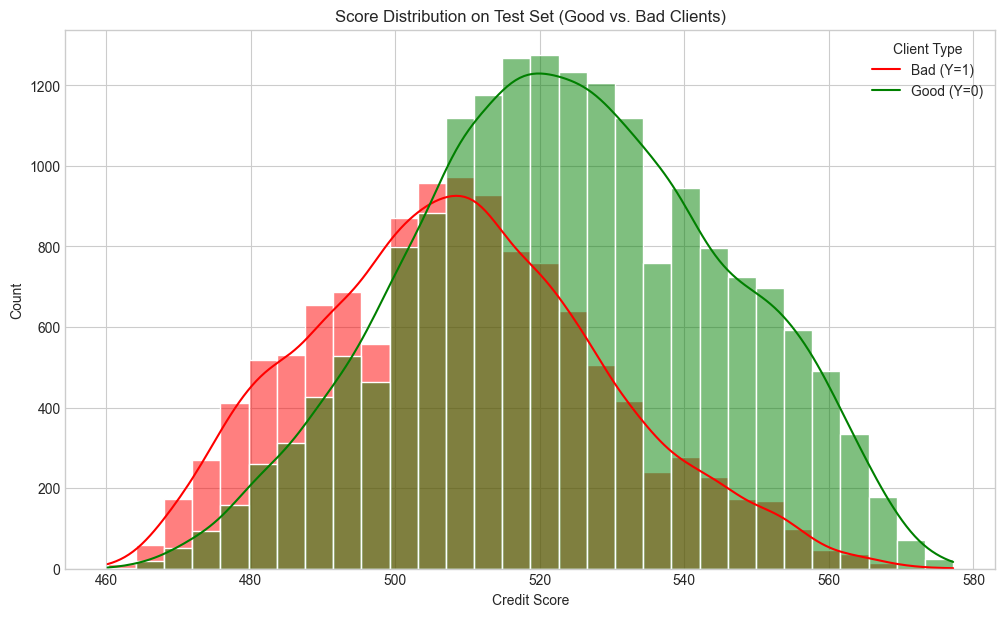

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

train_scores_df = pd.DataFrame({'score': train_scores, 'label': y_train})
test_scores_df = pd.DataFrame({'score': test_scores, 'label': y_test})

plt.figure(figsize=(12, 7))
sns.histplot(data=test_scores_df, x='score', hue='label', bins=30, kde=True, palette={0: 'green', 1: 'red'})
plt.title('Score Distribution on Test Set (Good vs. Bad Clients)')
plt.xlabel('Credit Score')
plt.ylabel('Count')
plt.legend(title='Client Type', labels=['Bad (Y=1)', 'Good (Y=0)'])
plt.show()

--- 开始进行模型补充验证 ---

--- 1. 评分分布量化分析 (测试集) ---


,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,18000.0,523.612454,21.449326,463.190343,508.190343,523.190343,539.190343,577.190343
1,12000.0,508.557760,20.233299,460.190343,494.190343,508.190343,522.190343,577.190343



--- 2. 生成增益图 (测试集) ---


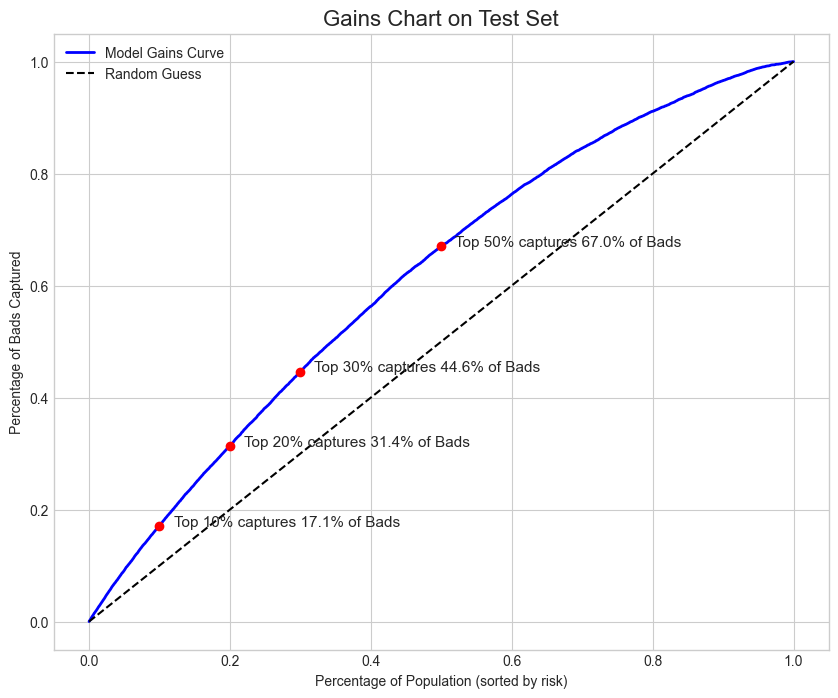


--- 3. 计算群体稳定性指数 (PSI) ---
最终分数PSI (Train vs Test): 0.0008


In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print("--- 开始进行模型补充验证 ---")
print("\n--- 1. 评分分布量化分析 (测试集) ---")
# 假设 test_scores 和 y_test 变量已在环境中
test_scores_df = pd.DataFrame({'score': test_scores, 'label': y_test})
score_stats = test_scores_df.groupby('label')['score'].describe()
display(score_stats)

print("\n--- 2. 生成增益图 (测试集) ---")

def plot_gains_chart(y_true, y_pred_proba, title='Gains Chart'):
    df = pd.DataFrame({'y_true': y_true, 'y_pred_proba': y_pred_proba}).sort_values(by='y_pred_proba', ascending=False)

    df['cum_pop_pct'] = np.arange(1, len(df) + 1) / len(df)
    df['cum_bad_pct'] = df['y_true'].cumsum() / df['y_true'].sum()

    plt.figure(figsize=(10, 8))
    plt.plot(df['cum_pop_pct'], df['cum_bad_pct'], label='Model Gains Curve', color='blue', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

    plt.xlabel('Percentage of Population (sorted by risk)')
    plt.ylabel('Percentage of Bads Captured')
    plt.title(title, fontsize=16)
    plt.legend()
    plt.grid(True)

    for q in [0.1, 0.2, 0.3, 0.5]:
        val = df.iloc[int(len(df) * q) - 1]
        plt.scatter(val['cum_pop_pct'], val['cum_bad_pct'], c='red', zorder=5)
        plt.text(val['cum_pop_pct'] + 0.02, val['cum_bad_pct'], f"Top {q*100:.0f}% captures {val['cum_bad_pct']*100:.1f}% of Bads", fontsize=11)

    plt.show()

plot_gains_chart(y_test, y_test_pred_proba, title='Gains Chart on Test Set')

print("\n--- 3. 计算群体稳定性指数 (PSI) ---")

def calculate_psi_universal(base_series, new_series, bins=10):
    base_series = pd.Series(base_series).dropna()
    new_series = pd.Series(new_series).dropna()

    if pd.api.types.is_numeric_dtype(base_series):
        bin_edges = np.quantile(base_series, q=np.linspace(0, 1, bins + 1))
        bin_edges[0], bin_edges[-1] = -np.inf, np.inf
        base_distr = pd.cut(base_series, bins=bin_edges).value_counts(normalize=True, sort=False)
        new_distr = pd.cut(new_series, bins=bin_edges).value_counts(normalize=True, sort=False)

    else:
        all_categories = list(set(base_series.unique()) | set(new_series.unique()))
        base_distr = base_series.value_counts(normalize=True).reindex(all_categories, fill_value=0)
        new_distr = new_series.value_counts(normalize=True).reindex(all_categories, fill_value=0)
    base_distr[base_distr == 0] = 0.0001
    new_distr[new_distr == 0] = 0.0001

    psi_values = (new_distr - base_distr) * np.log(new_distr / base_distr)
    return psi_values.sum()
psi_value_score = calculate_psi_universal(train_scores, test_scores)
print(f"最终分数PSI (Train vs Test): {psi_value_score:.4f}")
